# Notebook "1_Besoin_3_Lissage_temporelle"


## Description

Ce notebook se focalise sur l'étude du lissage commencée par Abdel lors de la première mission

## Structure du notebook

Ce notebook est construit de plusieurs parties :
- I. Import des bibliothèques
- II. Chargement des données et des profils
- III. Application du lissage
- IV. Application du lissage avec pondération
- V. Comparaison entre avec et sans pondération

## Prérequis

### Source de données

Pour que le notebook fonctionne, il est nécessaire que le fichier project_config.yml soit situé au même niveau que ce notebook : ce fichier permet la connexion à la source de données.

### Installation des prérequis techniques

Le notebook fonctionne sur Python 3.7 avec les bibliothèques suivantes :
- pandas
- psycopg2
- sqlachemy
- sklearn
- numpy
- yaml
- matplotlib

# Introduction

Initialement, la résolution par la méthode Lasso consiste à résoudre un système d'équations qui correspond à un instant t donné.

Le principe du lissage est de prendre en compte les échantillons du passé. Ainsi, un lissage prenant en compte n échantillons correspond à un système d'équations pour les échantillons à t, t-1, ..., t-n+1 

Le notebook se focalise seulement sur les données du SIRTA et sur une courte période

# I - Import des bibliothèques

In [2]:
# handling postgres database
import psycopg2
import pandas.io.sql as sqlio
import pandas as pd 
from sqlalchemy import create_engine
from io import StringIO
from sklearn.linear_model import Lasso
from sklearn import metrics
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yaml
from IPython.display import clear_output

# II - Chargement des données et des profils

## II.a Recherche des identifiants de connexion

In [3]:
with open(r'.\project_config.yml') as file:
    dbInfo = yaml.load(file, Loader=yaml.FullLoader)
    HOSTNAME = dbInfo["project-database"]["hostname"]
    DATABASE = dbInfo["project-database"]["name"]
    USER = dbInfo["project-database"]["user"]
    PASSWORD = dbInfo["project-database"]["password"]
    PORT = "5432"

## II.b Recherche des profils dans la DB

In [4]:
query = "SELECT * FROM public.profiles"
connection = psycopg2.connect(user = USER, password = PASSWORD, host = HOSTNAME, port = PORT, database = DATABASE)
df = sqlio.read_sql_query(query, connection)
connection.close()

OperationalError: could not translate host name "13.postgresql.dev.asterix.heka.ai" to address: Unknown host


In [4]:
pro = pd.unique(df['profile'])
pro

array(['BBOA', 'HOA', 'LO-OOA', 'MO-OOA'], dtype=object)

In [5]:
df = df.pivot(index="mass", columns='profile', values='value')
df = df.reset_index()
df = df.rename(columns={"mass" : "amus"})
df

profile   amus     BBOA      HOA   LO-OOA   MO-OOA
0         13.0  0.00189  0.00129  0.00430  0.00387
1         15.0  0.05999  0.00033  0.03545  0.00616
2         16.0  0.00621  0.00074  0.00787  0.01103
3         17.0  0.03883  0.00461  0.04919  0.06893
4         18.0  0.15533  0.01844  0.19675  0.27572
..         ...      ...      ...      ...      ...
67        96.0  0.00359  0.00499  0.00214  0.00233
68        97.0  0.00309  0.01834  0.00203  0.00185
69        98.0  0.00114  0.00634  0.00133  0.00122
70        99.0  0.00344  0.00393  0.00234  0.00186
71       100.0  0.00177  0.00084  0.00090  0.00072

[72 rows x 5 columns]

## II.c Recherche des données temporelles

In [6]:
## SELECTION DE LA DATE
start_date = '2015-03-01'
end_date = '2015-03-15'
## FIN DE LA SELECTION DE LA DATE

sql = f"""SELECT to_char(date, 'YYYY-MM-DD HH24:00:00') FROM(SELECT date FROM public.data_receptor 
          WHERE date>='{start_date}' AND date<='{end_date}' GROUP BY 1 ORDER BY 1) AS foo;"""
connection = psycopg2.connect(user = USER, password = PASSWORD, host = HOSTNAME, port = PORT, database = DATABASE)
df_dates = sqlio.read_sql_query(sql, connection)
connection.close()
dates = df_dates.T.values[0]

## II.d Recherche des erreurs de la PMF

In [7]:
connection = psycopg2.connect(user = USER, password = PASSWORD, host = HOSTNAME, port = PORT, database = DATABASE)
error_PMF_MAE = []
error_PMF_MSE = []
for date in dates:
    query_MAE = f"""
    SELECT date, AVG(error)
    FROM public.model_error
    WHERE model='PMF' AND error_type='MAE'
    GROUP BY date
    HAVING date = '{date}'
    LIMIT 10
    """
    error_MAE = sqlio.read_sql_query(query_MAE, connection).values
    error_PMF_MAE.append(error_MAE[0][1])

    query_MSE = f"""
    SELECT date, AVG(error)
    FROM public.model_error
    WHERE model='PMF' AND error_type='MSE'
    GROUP BY date
    HAVING date = '{date}'
    LIMIT 10
    """
    error_MSE = sqlio.read_sql_query(query_MSE, connection).values
    error_PMF_MSE.append(error_MSE[0][1])
connection.close()

## II.e Récupération des données brutes

In [8]:
connection = psycopg2.connect(user = USER, password = PASSWORD, host = HOSTNAME, port = PORT, database = DATABASE)
query = f"SELECT * FROM public.data_receptor WHERE date > '{start_date}' AND date <= '{end_date}'"
df_receptor = sqlio.read_sql_query(query, connection)
connection.close()

df_pivot = df_receptor.pivot_table(values="value", columns="mass", index="date")
df_pivot = df_pivot.sort_values("date")
df_array = df_pivot.reset_index().values
df_array = [i[1:] for i in df_array]

## II.f Récupération des regressions

In [9]:
connection = psycopg2.connect(user = USER, password = PASSWORD, host = HOSTNAME, port = PORT, database = DATABASE)
query = f"SELECT * FROM public.regressor_results WHERE date > '{start_date}' AND date <= '{end_date}' AND model='PMF'"
df_regressor = sqlio.read_sql_query(query, connection)
connection.close()

# III - Application du lissage

## III.a Choix du nombre d'échantillons à prendre en compte

In [10]:
list_pas = [1,3,5,7,9]

In [11]:
lissage_brute = []
for pas in list_pas:
    result = []
    for index, date in enumerate(dates[pas:]):
        result.append(np.mean(df_array[index: index + pas], axis = 0))
    lissage_brute.append(result)

## III.b Mise en place de l'algorithme de lissage (sans pondération)

In [12]:
result = []
result_construct = []
result_error_MAE = []
result_error_MSE = []
result_error_MAE_modified = []
result_error_MSE_modified = []
connection = psycopg2.connect(user = USER, password = PASSWORD, host = HOSTNAME, port = PORT, database = DATABASE)

for index_pas, pas in enumerate(list_pas):
    contirubtion = [[] for i in pro]
    contribution_mae = []
    contribution_mse = []
    contribution_mae_modified = []
    contribution_mse_modified = []
    result_construct.append([])
    c = []
    for index_date, i in enumerate(dates[pas:]):    
        date = i

        ## Collect the receptor data
        sql = f"""SELECT * FROM public.data_receptor where date = '{date}' """
        for k in range(1, pas):
            date_intemediaire = df_dates.iloc[k].values[0]
            sql += f"or date = '{date_intemediaire}'"
        sql += "order by mass;"
        df_receptor_data = sqlio.read_sql_query(sql, connection)
        df_receptor_data = df_receptor_data[df_receptor_data.columns]

        df_receptor_data_ref = df_receptor_data[df_receptor_data["date"]==i]["value"].values

        cor = df.merge(df_receptor_data, left_on='amus', right_on='mass').drop(columns=['mass', 'amus'])

        # Choose variables
        X_train = cor[pro].values
        y_train = cor['value'].values.reshape(-1,1)

        # Training 
        #  Model
        alpha = 0.001
        lasso = Lasso(fit_intercept=False, alpha=alpha, positive=True)
        lasso.fit(X_train, y_train)
                             
        clear_output(wait=True)                                          
        print(pas, ' ', date)
        for n, prof in enumerate(pro):
            contirubtion[n].append(lasso.coef_[n])

        # Constructed signal
        data_profile = df[pro].values
        construct = np.dot(data_profile, lasso.coef_)
        result_construct[index_pas].append(construct)

        # MAE error
        error_mae = np.sum(np.abs(construct - df_receptor_data_ref)) / len(df_receptor_data_ref)
        contribution_mae.append(error_mae)

        # MSE error
        error_mse = np.sum(np.abs(construct**2 - df_receptor_data_ref**2)) / len(df_receptor_data_ref)
        contribution_mse.append(error_mse)

        # MAE error with modified signal
        error_mae = np.sum(np.abs(construct - lissage_brute[index_pas][index_date])) / len(construct)
        contribution_mae_modified.append(error_mae)
        c.append(np.abs(construct - lissage_brute[index_pas][index_date]))

        # MSE error with modified signal
        error_mse = np.sum(np.abs(construct**2 - lissage_brute[index_pas][index_date]**2)) / len(construct)
        contribution_mse_modified.append(error_mse)

    result.append(contirubtion)
    result_error_MSE.append(contribution_mse)
    result_error_MAE.append(contribution_mae)
    result_error_MSE_modified.append(contribution_mse_modified)
    result_error_MAE_modified.append(contribution_mae_modified)

connection.close()
print("Done")

9   2015-03-15 00:00:00
Done


In [13]:
np.sum(np.abs(result_construct[0][0] - lissage_brute[0][1]))

0.7606828130000003

In [14]:
len(result_error_MSE[0])

336

## III.c Affichage superposé des différents lissages

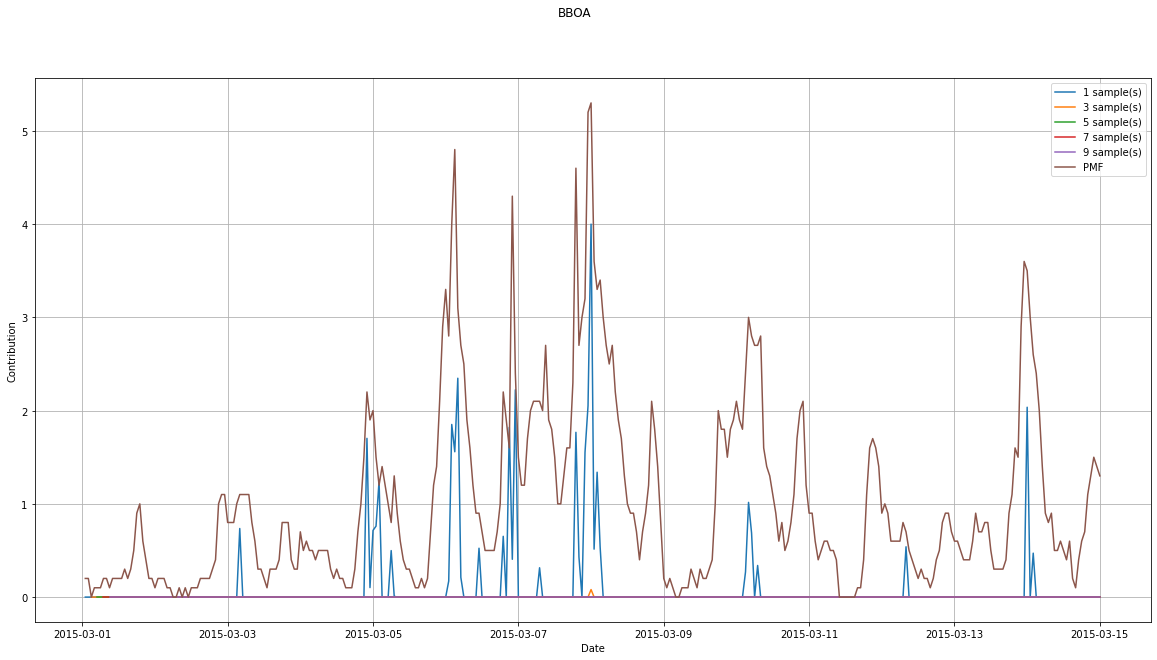

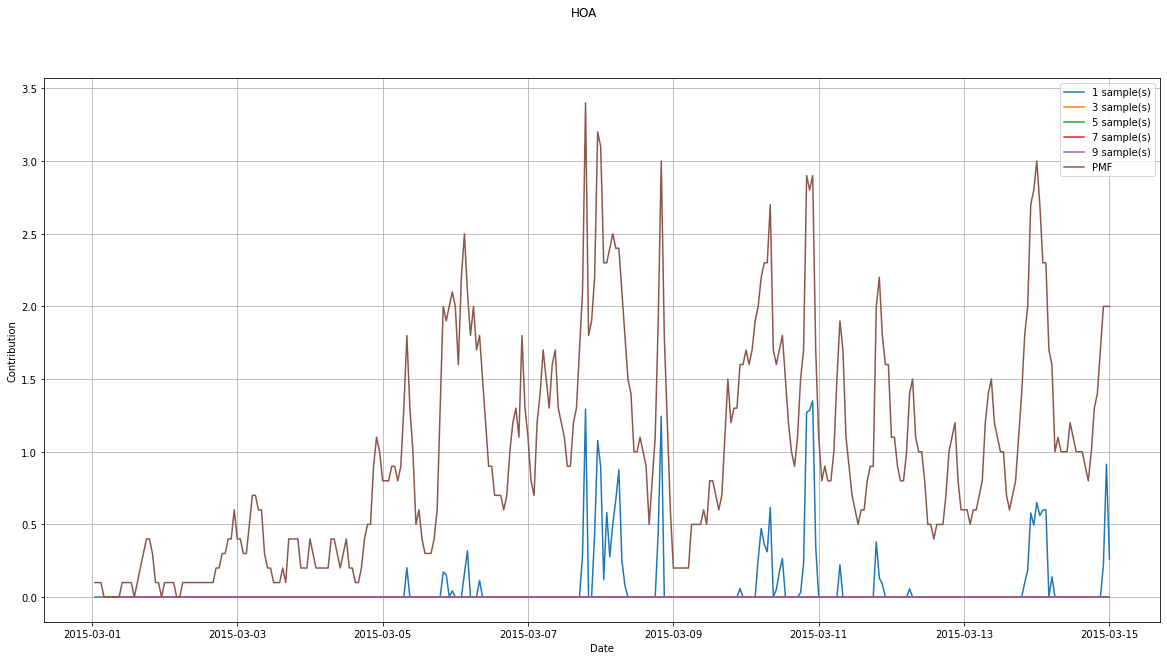

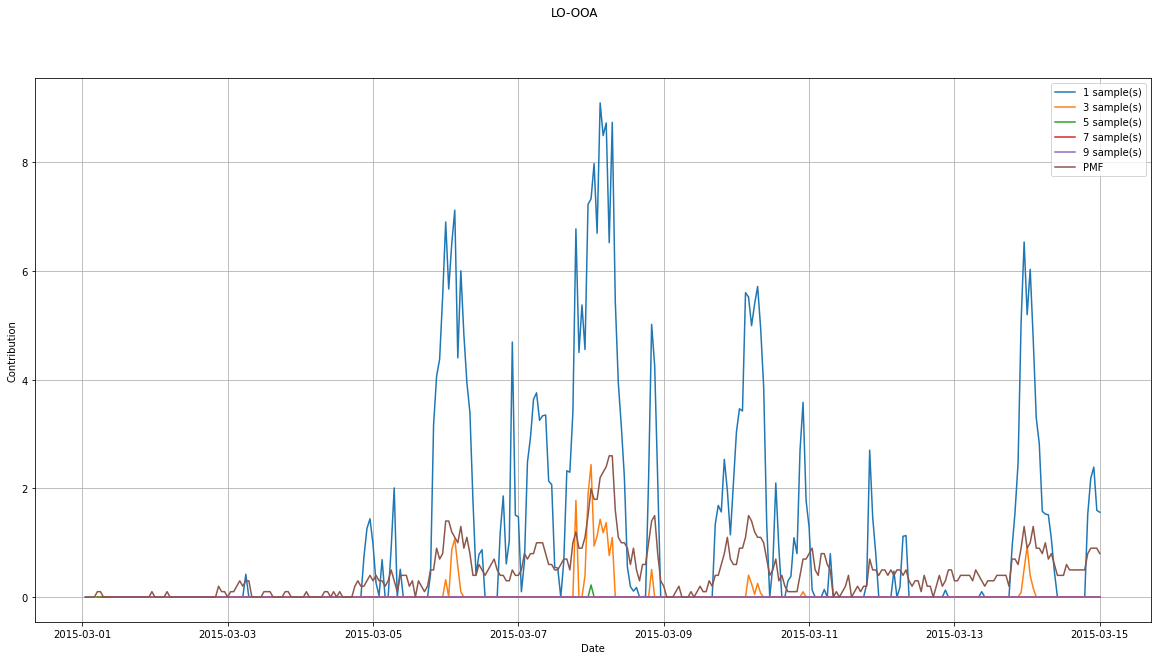

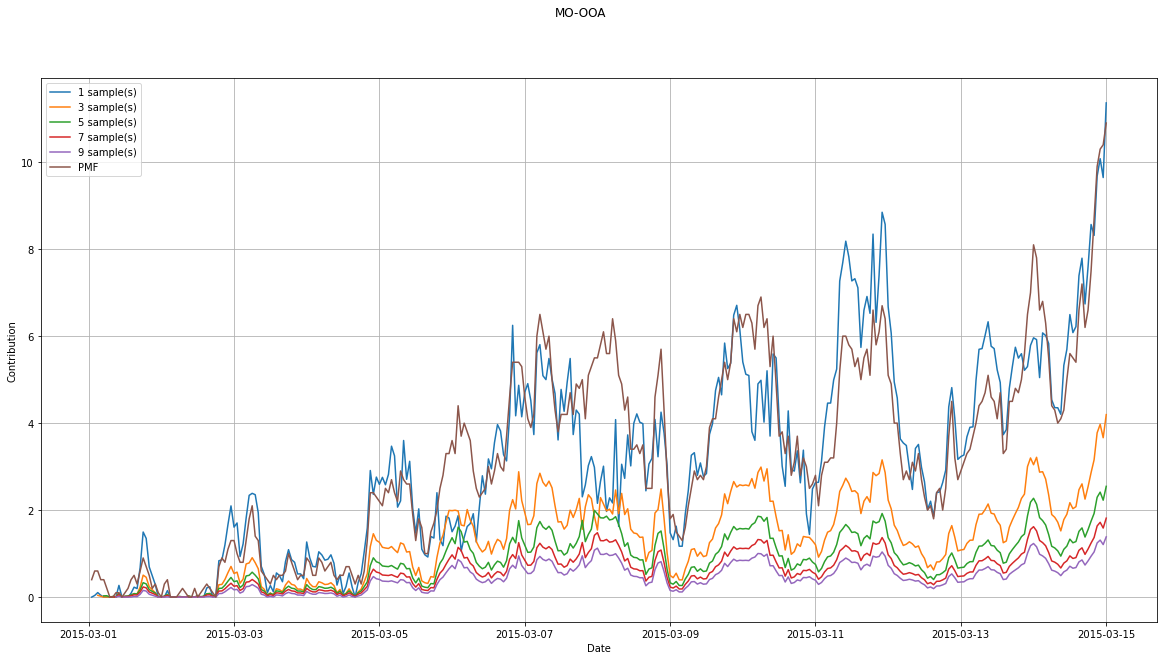

In [15]:
plt.rcParams["figure.figsize"] = (20,10)
for n, prof in enumerate(pro):
    fig, ax = plt.subplots()
    fig.suptitle(prof)
    for i, pas in enumerate(list_pas):
        ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result[i][n], label=f'{pas} sample(s)')
    ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[1:]], df_regressor[df_regressor["profile"] == prof].sort_values(by="date")["contribution"].values, label='PMF')
    plt.xlabel("Date")
    plt.ylabel("Contribution")
    plt.grid()
    plt.legend()
    plt.show()

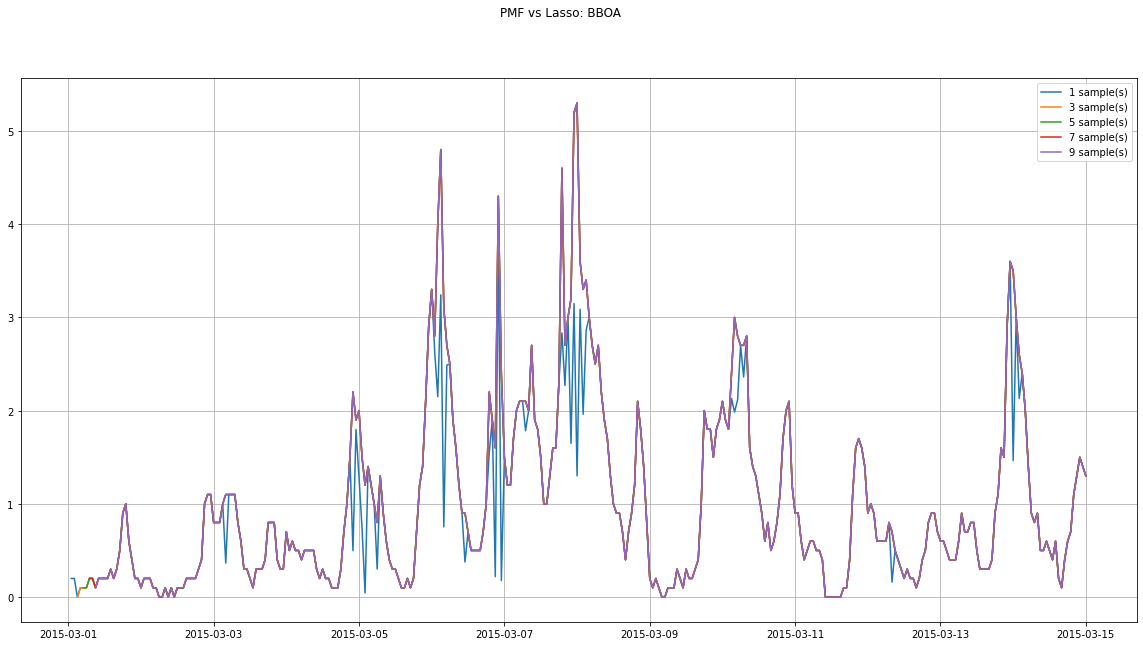

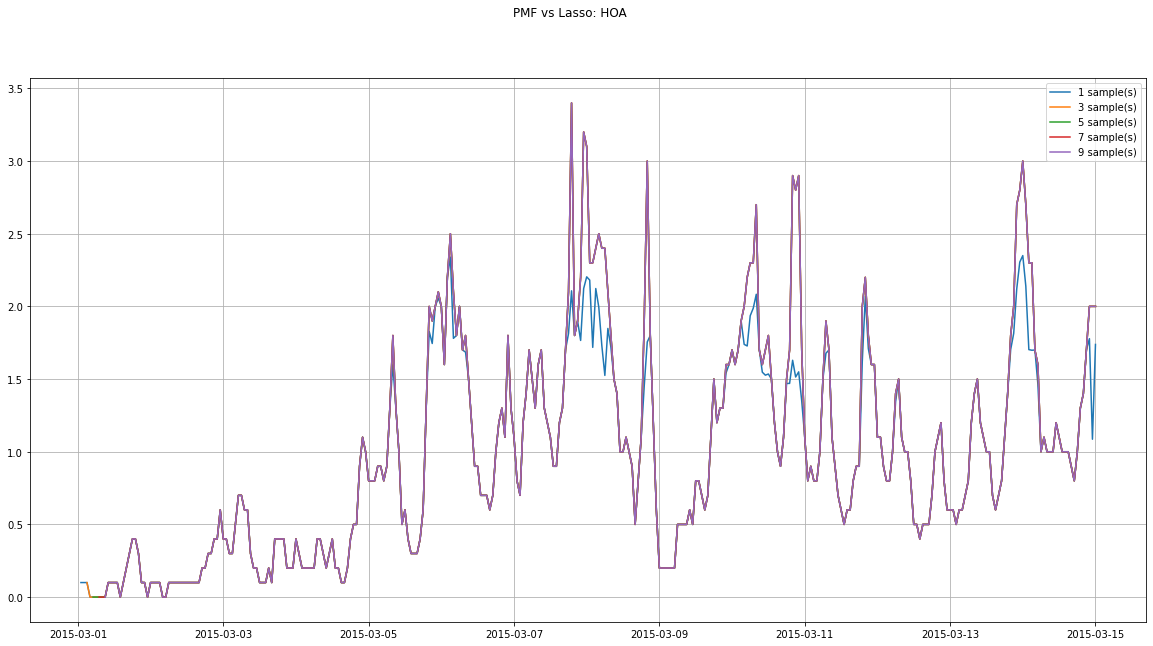

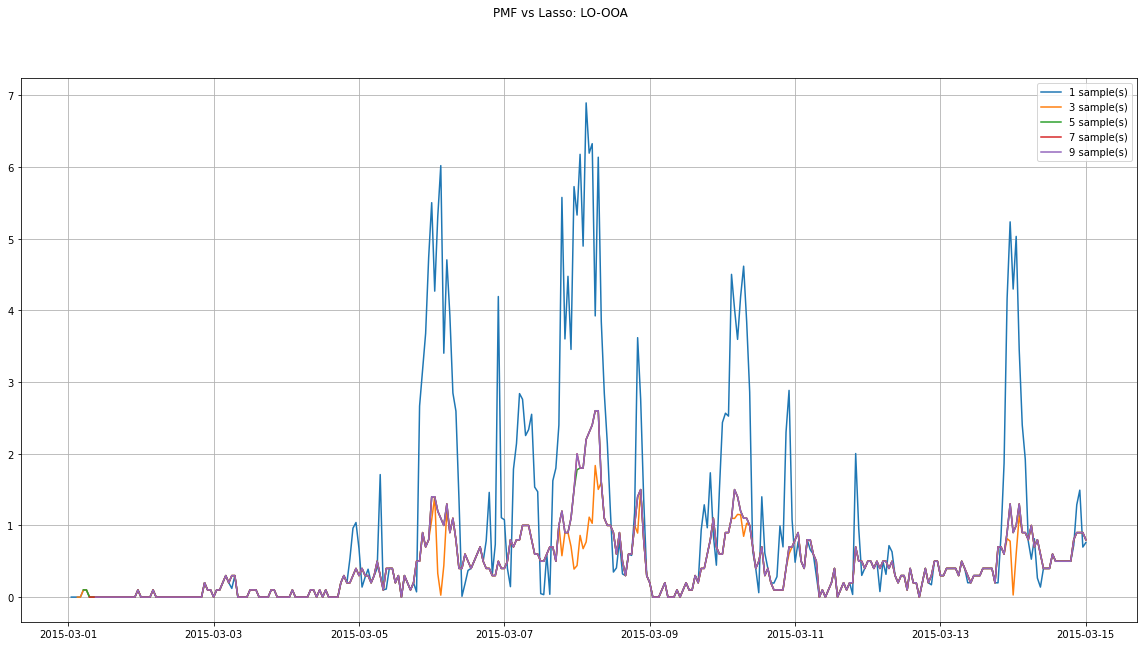

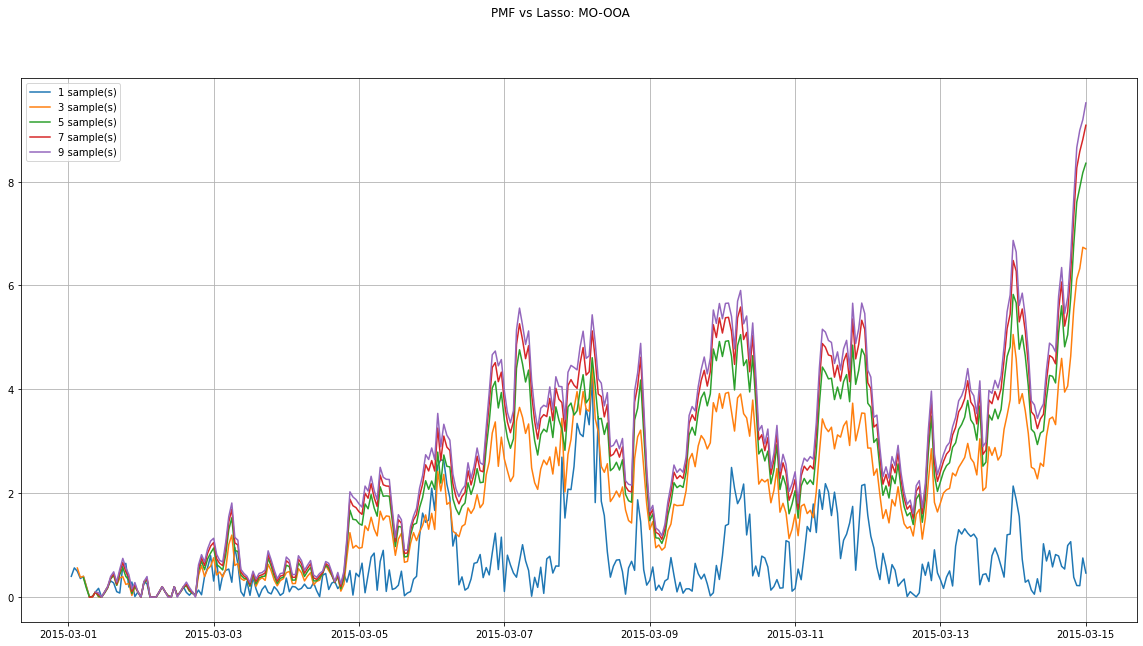

In [16]:
plt.rcParams["figure.figsize"] = (20,10)
for n, prof in enumerate(pro):
    fig, ax = plt.subplots()
    fig.suptitle("PMF vs Lasso: " + prof)
    for i, pas in enumerate(list_pas):
        ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], np.abs(result[i][n] - df_regressor[df_regressor["profile"] == prof].sort_values(by="date")["contribution"].values[pas - 1:]), label=f'{pas} sample(s)')
    plt.grid()
    plt.legend()
    plt.show()

## III.d Affichage séparé des différents lissages

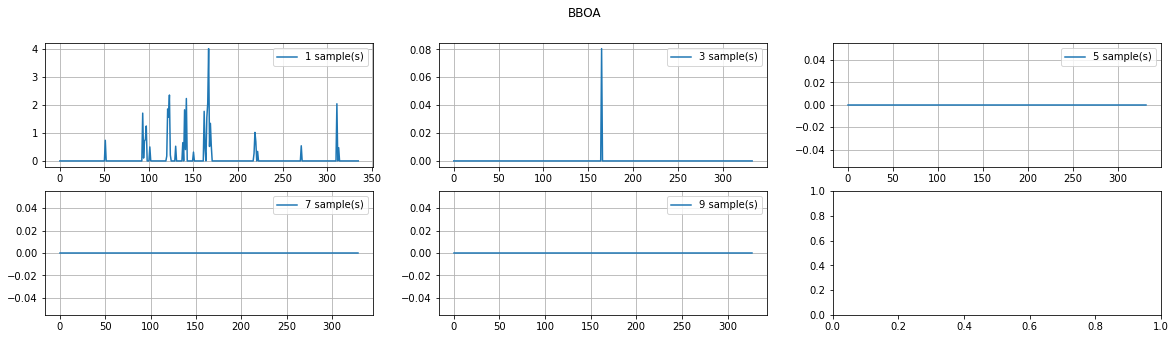

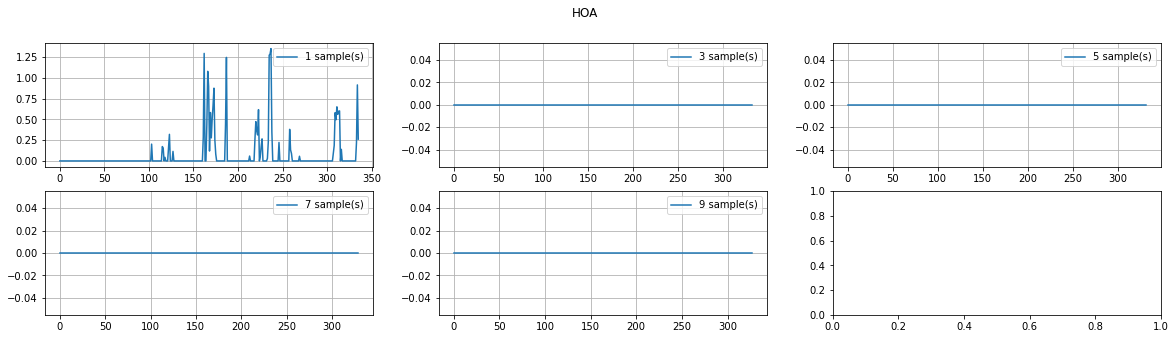

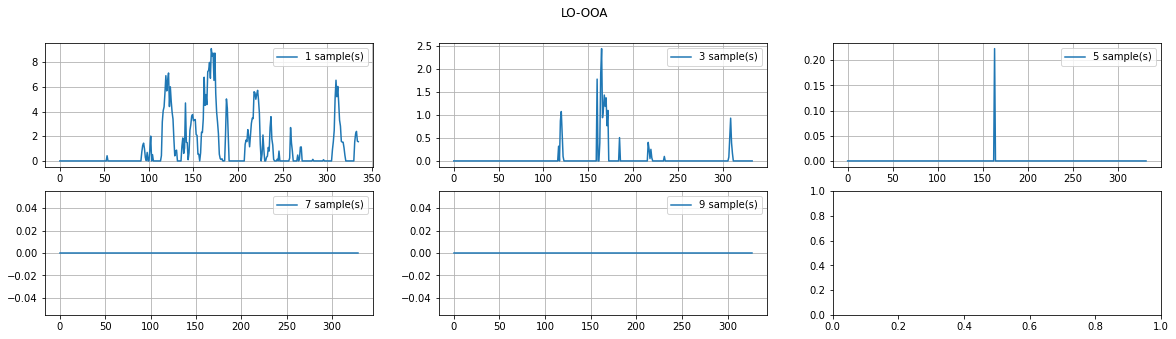

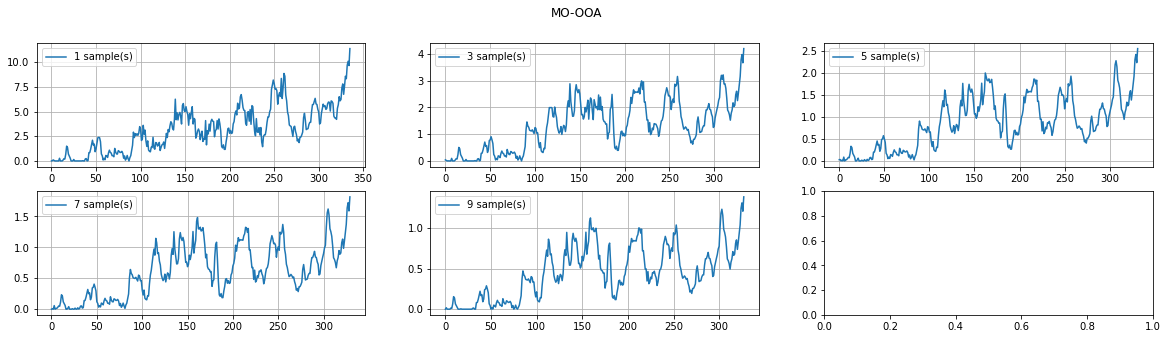

In [17]:
plt.rcParams["figure.figsize"] = (20,5)
for n, prof in enumerate(pro):
    fig, ax = plt.subplots(int(np.ceil(len(list_pas) / 3)), min(3, len(list_pas)))
    fig.suptitle(prof)
    for i, pas in enumerate(list_pas):
        row = int(np.floor(i / 3))
        col = i % 3
        if int(np.ceil(len(list_pas) / 3)) == 1:
            ax[col].plot(result[i][n], label=f'{pas} sample(s)')
            ax[col].grid()
            ax[col].legend()
        else:
            ax[row][col].plot(result[i][n], label=f'{pas} sample(s)')
            ax[row][col].grid()
            ax[row][col].legend()
    plt.show()

## III.e Affichage des erreurs

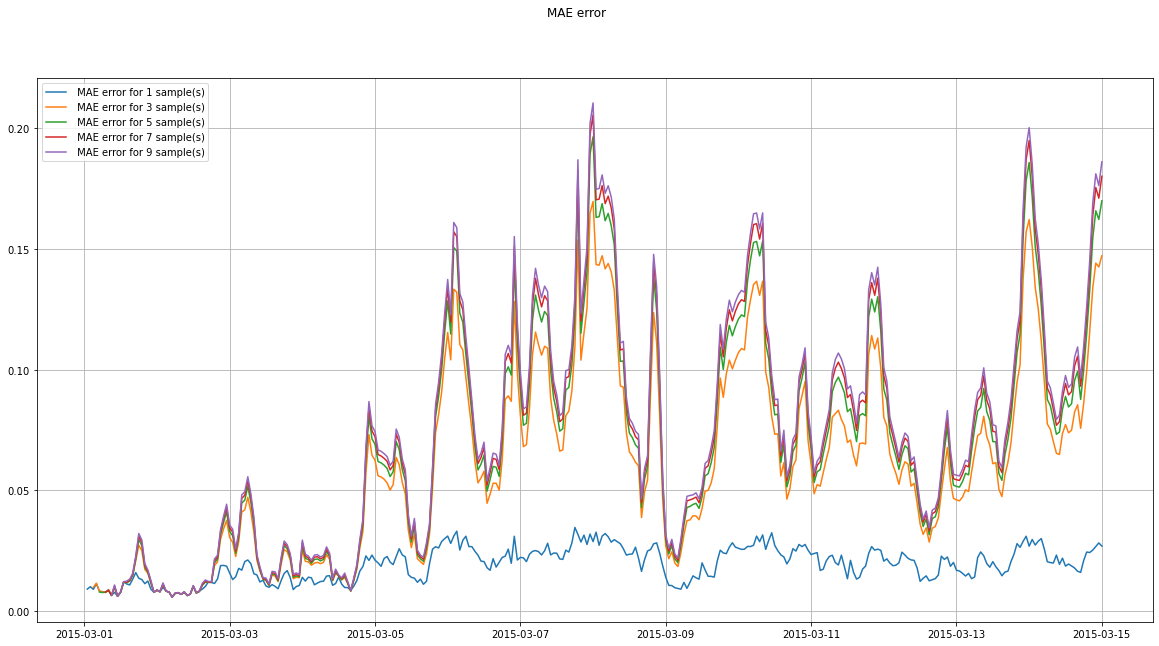

In [18]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MAE error")
for i, pas in enumerate(list_pas):
    ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_error_MAE[i], label=f' MAE error for {pas} sample(s)')
plt.grid()
plt.legend()
plt.show()

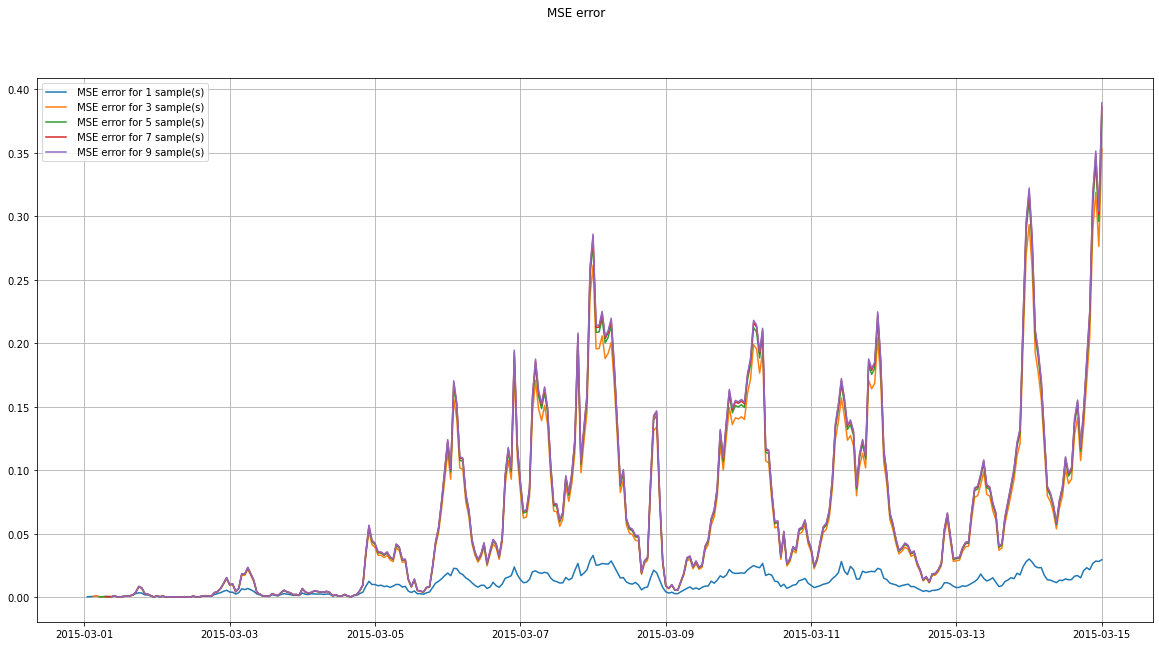

In [19]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MSE error")
for i, pas in enumerate(list_pas):
    ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_error_MSE[i], label=f' MSE error for {pas} sample(s)')
plt.grid()
plt.legend()
plt.show()

## III.f Affichage des erreurs avec le signal lissé

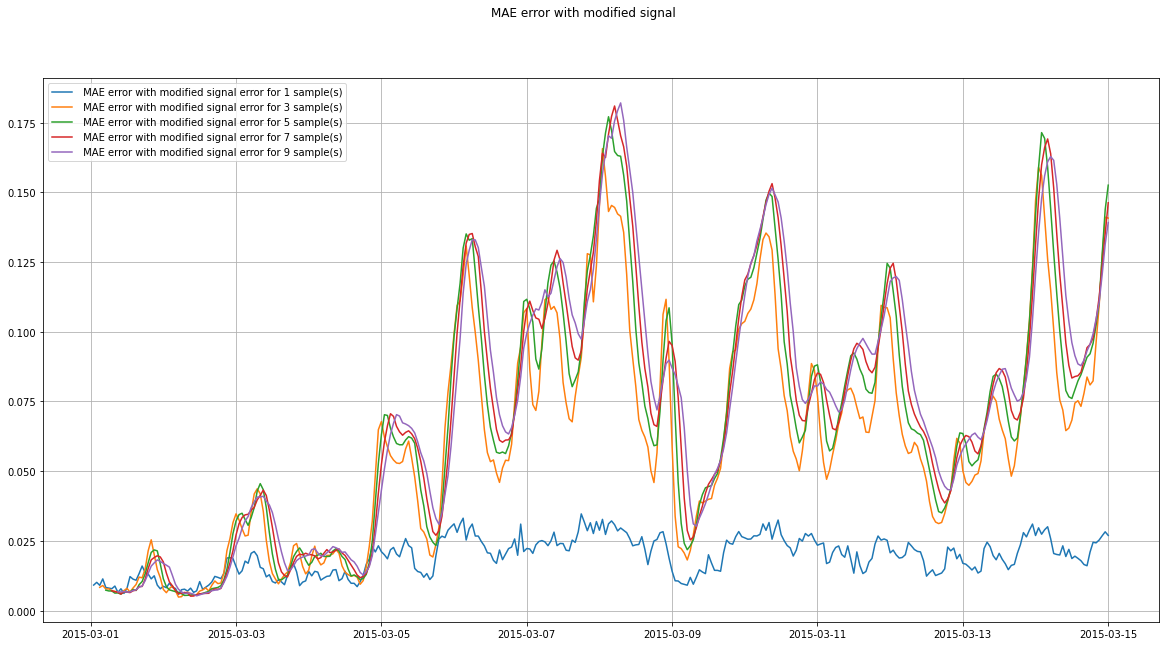

In [20]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MAE error with modified signal")
for i, pas in enumerate(list_pas):
    ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_error_MAE_modified[i], label=f' MAE error with modified signal error for {pas} sample(s)')
plt.grid()
plt.legend()
plt.show()

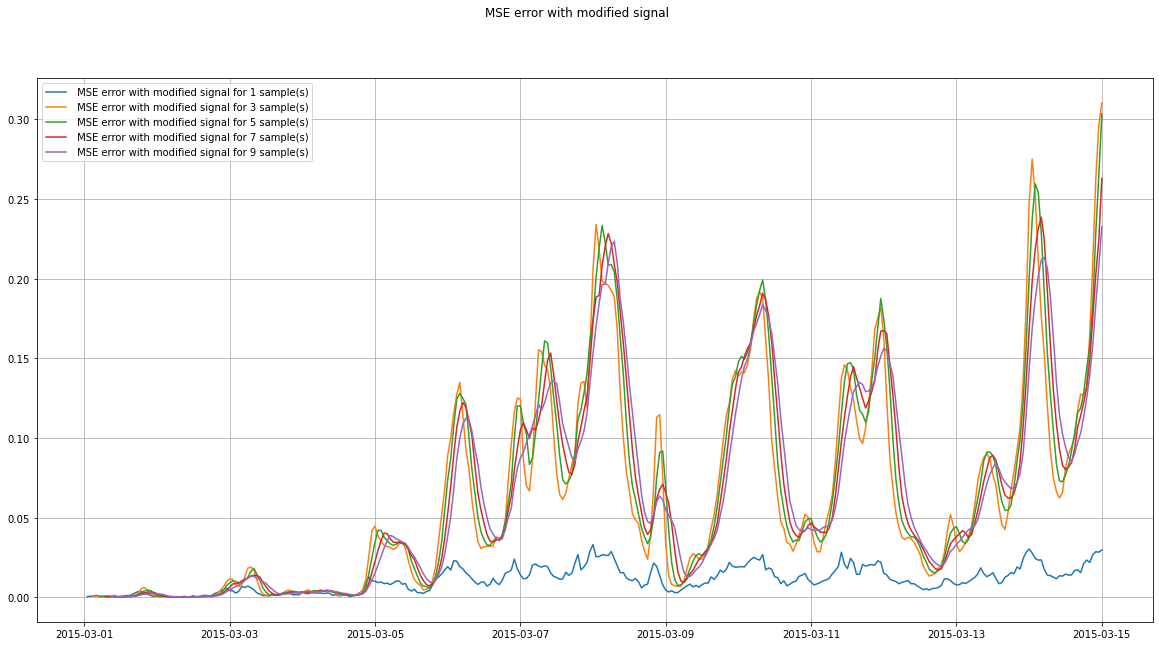

In [21]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MSE error with modified signal")
for i, pas in enumerate(list_pas):
    ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_error_MSE_modified[i], label=f' MSE error with modified signal for {pas} sample(s)')
plt.grid()
plt.legend()
plt.show()

## III.g Comparaison avec la PMF

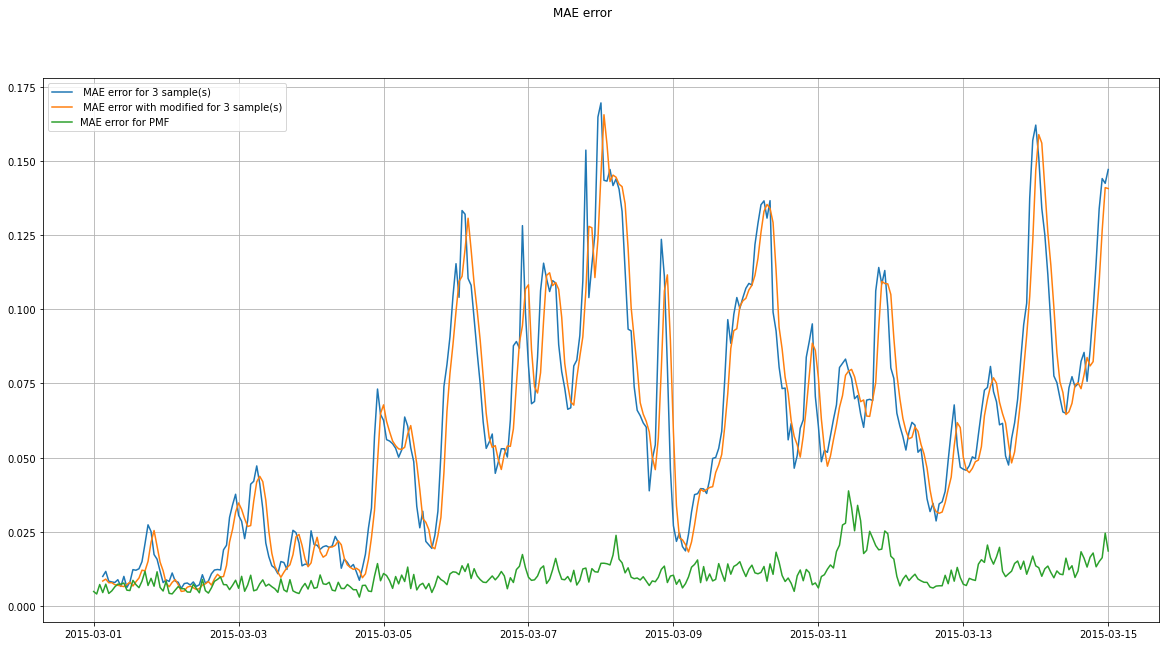

In [22]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MAE error")
i = 1
pas = list_pas[i]
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_error_MAE[i], label=f' MAE error for {pas} sample(s)')
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_error_MAE_modified[i], label=f' MAE error with modified for {pas} sample(s)')
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates], error_PMF_MAE, label="MAE error for PMF")
plt.grid()
plt.legend()
plt.show()

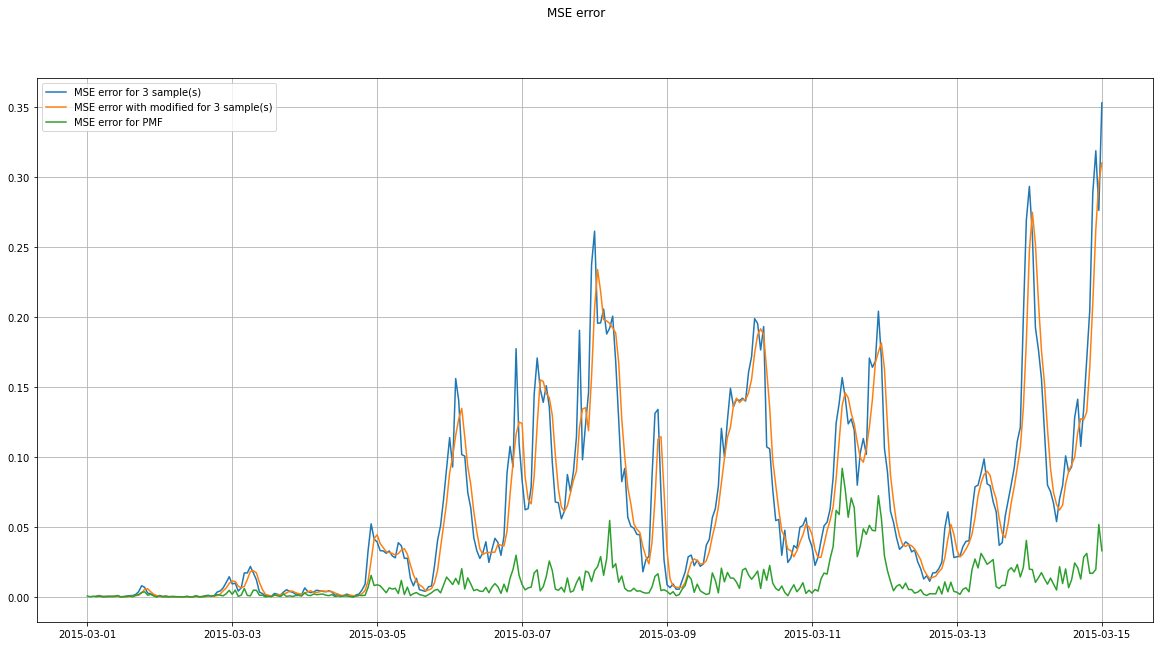

In [23]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MSE error")
i = 1
pas = list_pas[i]
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_error_MSE[i], label=f'MSE error for {pas} sample(s)')
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_error_MSE_modified[i], label=f'MSE error with modified for {pas} sample(s)')
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates], error_PMF_MSE, label="MSE error for PMF")
plt.grid()
plt.legend()
plt.show()

In [24]:
result_error_MAE[0]

[0.00917675225,
 0.010149028278652265,
 0.009088465316054428,
 0.011385304053548428,
 0.008309936944444445,
 0.008101102583333334,
 0.00787027236111111,
 0.008820957944444444,
 0.006551375569444444,
 0.007850488874422194,
 0.006202139194444445,
 0.00801752988888889,
 0.012217288777777776,
 0.01130637689993861,
 0.010906938490511078,
 0.013298377267068805,
 0.016004435463168532,
 0.013658603606342612,
 0.013124344065662315,
 0.011405972302414295,
 0.012504306591956092,
 0.009168762669950207,
 0.007843013458333332,
 0.008754294888888887,
 0.008233699875,
 0.009875210516833285,
 0.008329089625000001,
 0.007958516,
 0.005862781527777777,
 0.007513051902777778,
 0.007701971958333333,
 0.007022214374999999,
 0.008075176222222221,
 0.006548809541666667,
 0.007111030708333333,
 0.0104128922065393,
 0.007630821083333333,
 0.008389002680555554,
 0.009173112774542561,
 0.010271431189631133,
 0.012282294277777779,
 0.011943332232688869,
 0.011496787765467793,
 0.013369258414765299,
 0.018886339627

## III.i Observations

Observations faites sur les différents niveaux de lissage :
- Décalage temporel vers la doite : cela s'explique par le fait de ne prendre que les valeurs dans le passé. Ce déséquilibre crée un retard temporel par rapport aux valeurs sans lissage
- Plus le nombre d'échantillons à prendre augmente, plus le lissage est important
- Plus le lissage est important, plus les valeurs des contributions diminuent
- Plus le lissage est important, plus l'erreur par rapport aux valeurs initiales obtenues sur le site est importante
- Généralement, le lissage possède une erreur plus importante que celui de la PMF

# IV - Mise en application du lissage avec pondération linéaire

Principe de la méthode LASSO
- En entrée : un ensemble d'équations et une fonction de coût à minimiser
- La fonction de coût représente l'erreur totale par rapport au valeur cible (se calcule généralement à l'aide d'une distance)

La pondération du lissage dans la méthode LASSO se fait en pondérant les échantillons du passé dans la fonction de coût (plus l'échantillons est loin dans le passé, plus l'impact est faible). Le système d'équation est quant à lui identique.

Dans un premier temps, une pondération linéaire est mise en place. Pour n échantillons pris en compte :
- L'échantillon à t est pondéré à 1
- L'échantillon à t-1 est pondéré à 1 - 1/n
- ...
- L'échantillon à t-n+1 est pondéré à 1/n


## IV.a Choix du nombre d'échantillons à prendre en compte (2)

In [25]:
list_pas_2 = [1,3,5,7,9]

In [26]:
lissage_brute_2 = []
for pas in list_pas_2:
    result = []
    for index, date in enumerate(dates[pas:]):
        result_inter = []
        total_coef = 0
        for i in range(pas):
            coef = (i + 1) / pas
            total_coef += coef
            result_inter.append(coef*df_array[i + index])
        result.append(np.sum(result_inter, axis=0) / total_coef)
    lissage_brute_2.append(result)

## IV.b Mise en place de l'algorithme de lissage (avec pondération)

In [27]:
result_2 = []
result_2_error_MAE = []
result_2_error_MSE = []
result_2_error_MAE_modified = []
result_2_error_MSE_modified = []
connection = psycopg2.connect(user = USER, password = PASSWORD, host = HOSTNAME, port = PORT, database = DATABASE)
for index_pas, pas in enumerate(list_pas_2):
    contribution = [[] for i in pro]
    contribution_mae = []
    contribution_mse = []
    contribution_mae_modified = []
    contribution_mse_modified = []
    for index_date, i in enumerate(dates[pas:]):    
        date = i
        sql = f"""SELECT * FROM public.data_receptor where date = '{date}' """
        for k in range(1, pas):
            date_intemediaire = (datetime.strptime(date, '%Y-%m-%d %H:%M:%S')-timedelta(hours=k)).strftime('%Y-%m-%d %H:%M:%S')
            sql += f"or date = '{date_intemediaire}' "
        sql += "order by mass;"
        df_receptor_data = sqlio.read_sql_query(sql, connection)
        df_receptor_data = df_receptor_data[df_receptor_data.columns]

        df_receptor_data_ref = df_receptor_data[df_receptor_data["date"]==i]["value"].values

        # Ponderate values
        sum_total = np.sum([i/pas for i in range(1,pas+1)])
        for k in range(pas):
            date_target = (datetime.strptime(date, '%Y-%m-%d %H:%M:%S')-timedelta(hours=k)).strftime('%Y-%m-%d %H:%M:%S')
            df_receptor_data.loc[df_receptor_data["date"] == date_target, "coef"] = (pas - k) * 1/(pas * sum_total)
        cor = df.merge(df_receptor_data, left_on='amus', right_on='mass').drop(columns=['mass', 'amus'])

        X_train = cor[pro].values
        y_train = cor['value'].values.reshape(-1,1)

        for index, row in enumerate(X_train):
            X_train[index] = np.dot(row, cor['coef'].iloc[index])

        for index, row in enumerate(y_train):
            y_train[index] = np.dot(row, cor['coef'].iloc[index])

        alpha = 0.001
        lasso = Lasso(fit_intercept=False, alpha=alpha, positive=True)     # We train without intercept and we shoose to have only positive values
        lasso.fit(X_train, y_train)                                         #training the algorithm
        clear_output(wait=True)                                          
        print(pas, ' ', date)
        for n, prof in enumerate(pro):
            contribution[n].append(lasso.coef_[n])

        # Constructed signal
        data_profile = df[pro].values
        construct = np.dot(data_profile, lasso.coef_)

        # MAE error
        error_mae = np.sum(np.abs(construct - df_receptor_data_ref)) / len(df_receptor_data_ref)
        contribution_mae.append(error_mae)

        # MSE error
        error_mse = np.sum(np.abs(construct**2 - df_receptor_data_ref**2)) / len(df_receptor_data_ref)
        contribution_mse.append(error_mse)

        # MAE error with modified
        error_mae = np.sum(np.abs(construct - lissage_brute_2[index_pas][index_date])) / len(construct)
        contribution_mae_modified.append(error_mae)

        # MSE error with modified
        error_mse = np.sum(np.abs(construct**2 - lissage_brute_2[index_pas][index_date]**2)) / len(construct)
        contribution_mse_modified.append(error_mse)

    result_2.append(contribution)
    result_2_error_MSE.append(contribution_mse)
    result_2_error_MAE.append(contribution_mae)
    result_2_error_MSE_modified.append(contribution_mse_modified)
    result_2_error_MAE_modified.append(contribution_mae_modified)
connection.close()
print("Done")

9   2015-03-15 00:00:00
Done


## IV.c Affichage superposé des différents lissages avec pondération

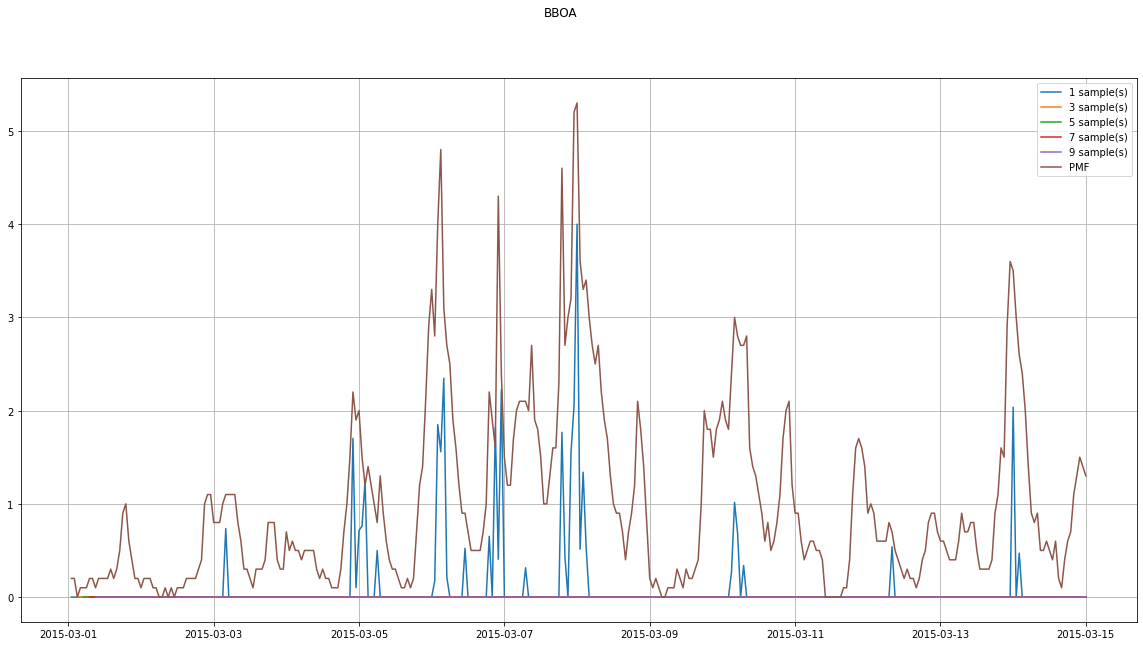

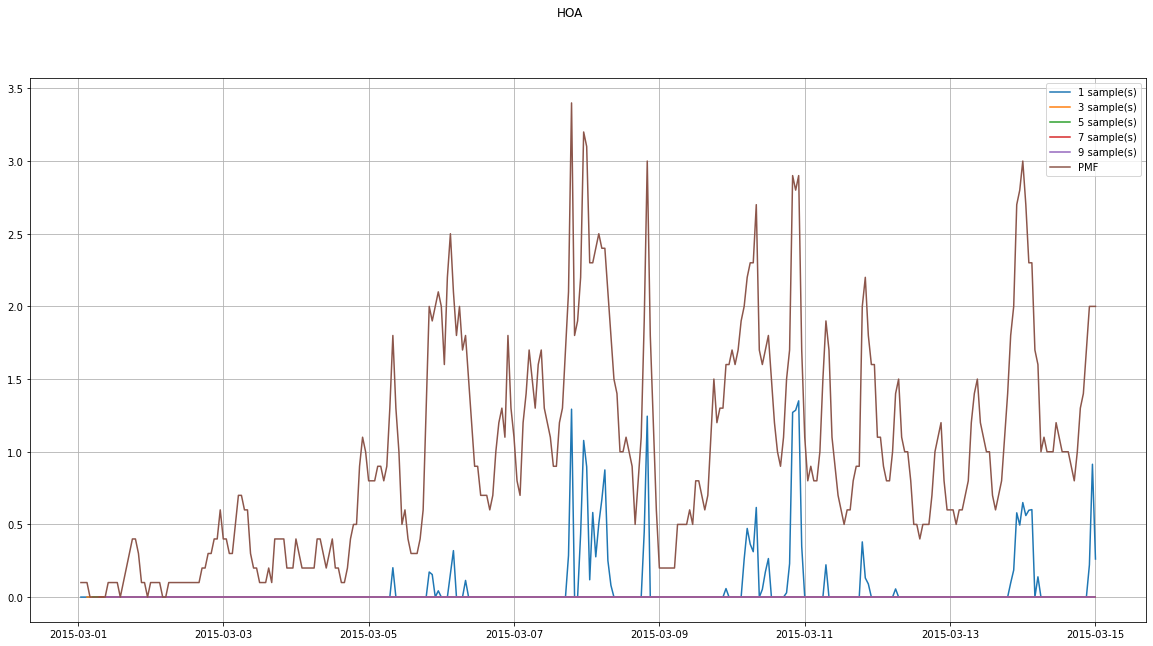

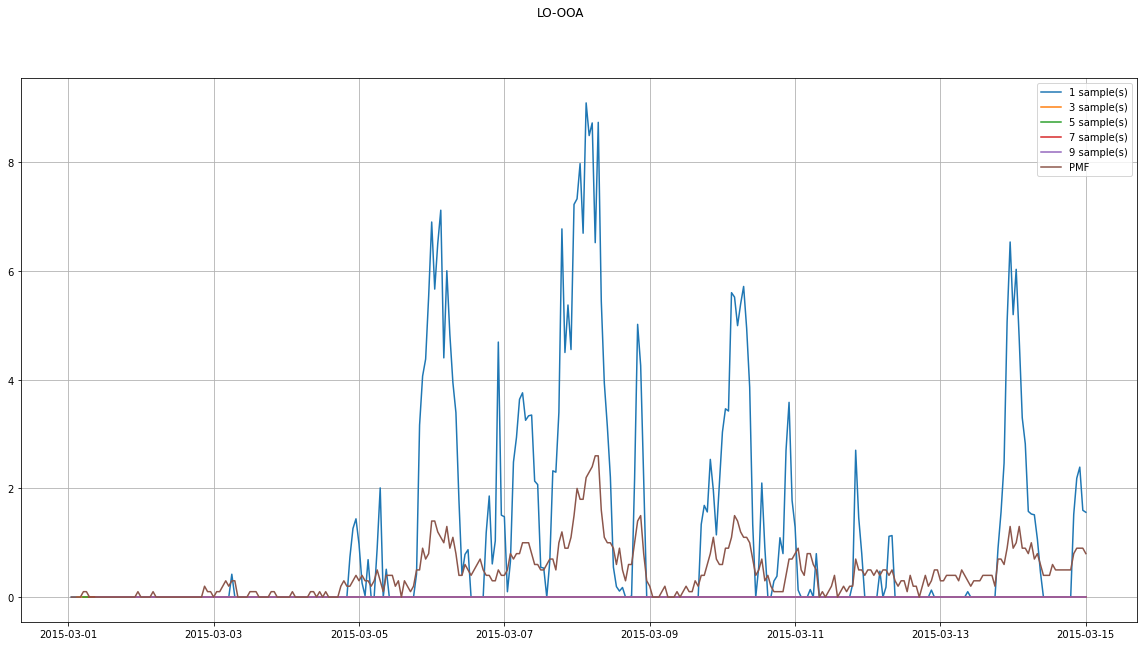

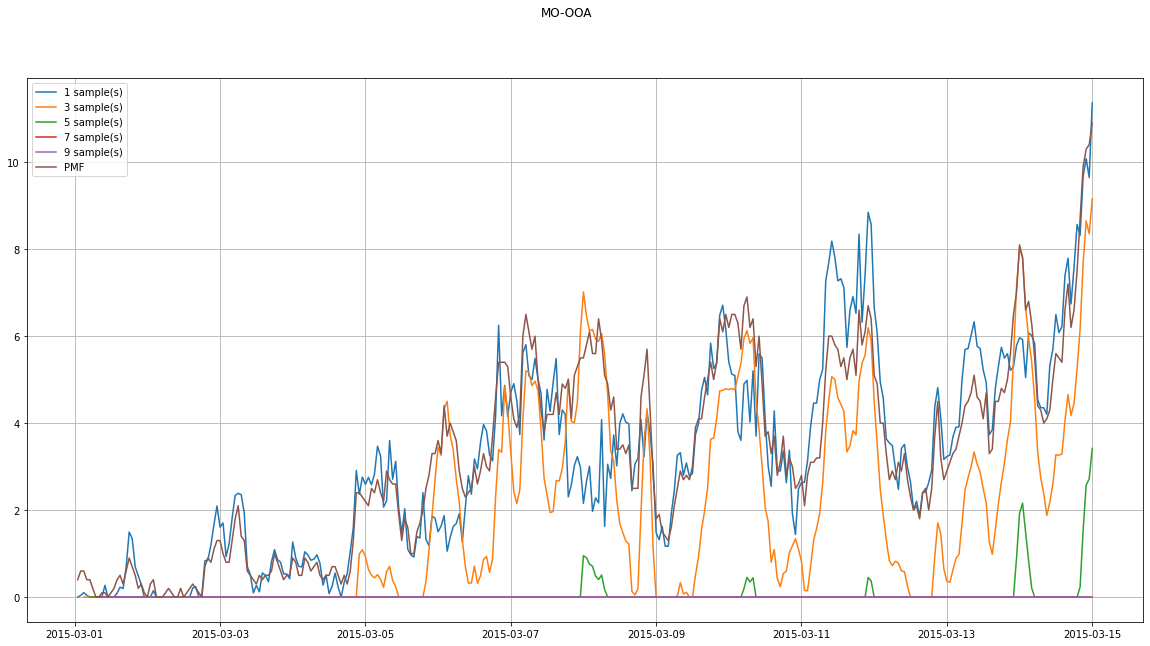

In [28]:
plt.rcParams["figure.figsize"] = (20,10)
for n, prof in enumerate(pro):
    fig, ax = plt.subplots()
    fig.suptitle(prof)
    for i, pas in enumerate(list_pas_2):
        ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_2[i][n], label=f'{pas} sample(s)')
    ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[1:]], df_regressor[df_regressor["profile"] == prof].sort_values(by="date")["contribution"].values, label='PMF')
    plt.grid()
    plt.legend()
    plt.show()

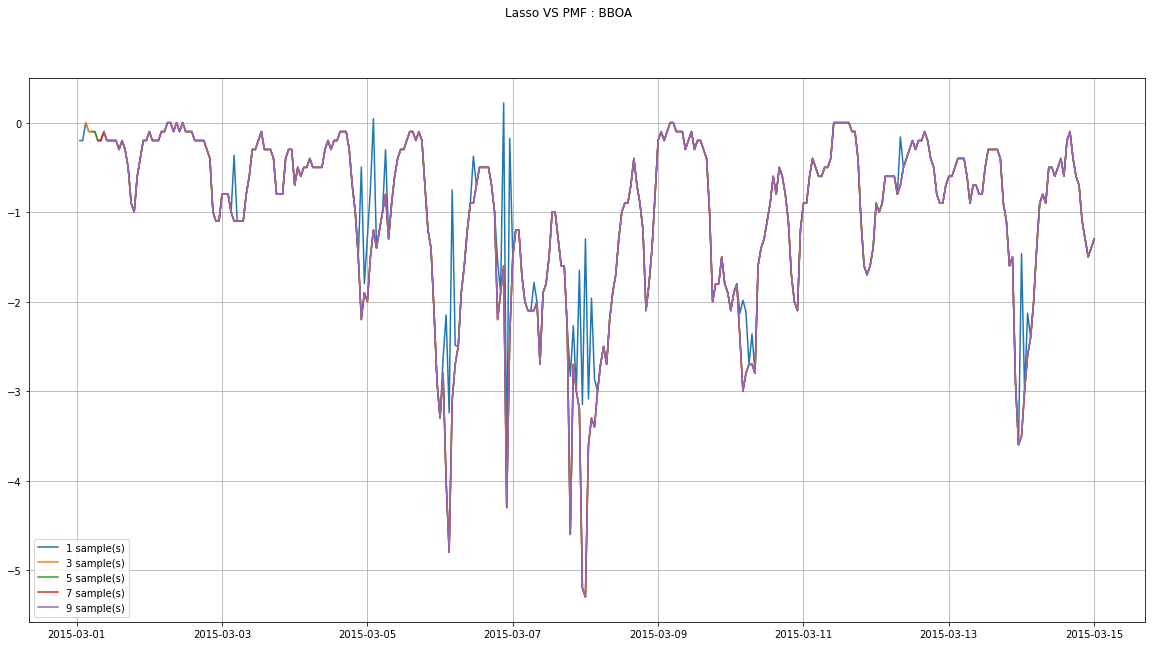

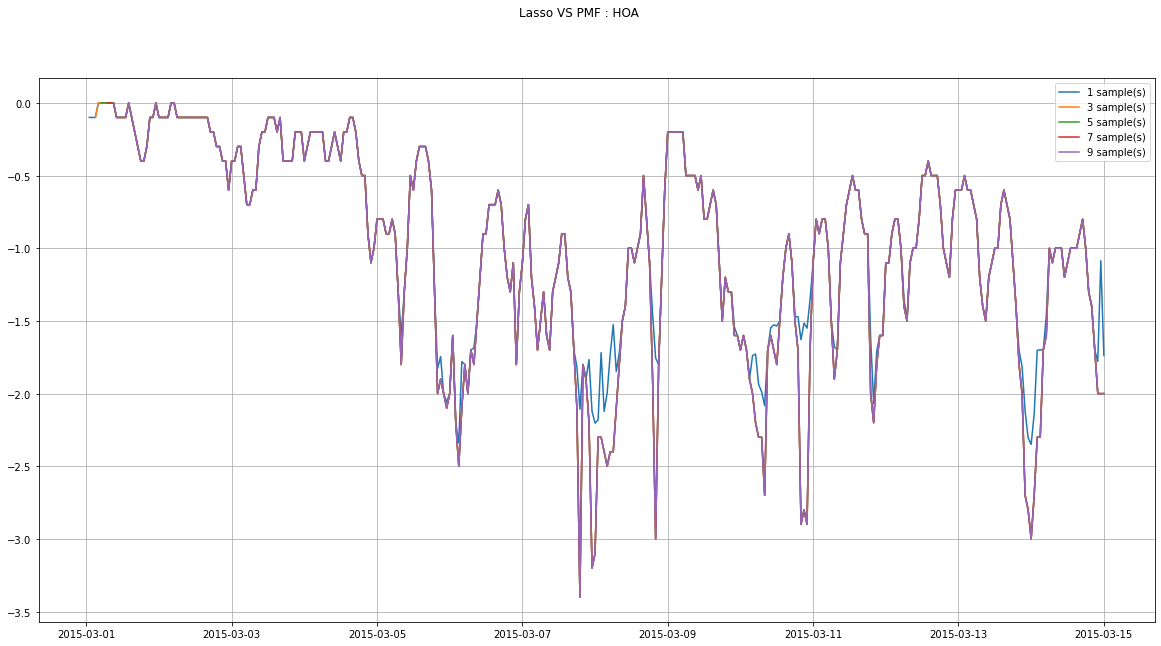

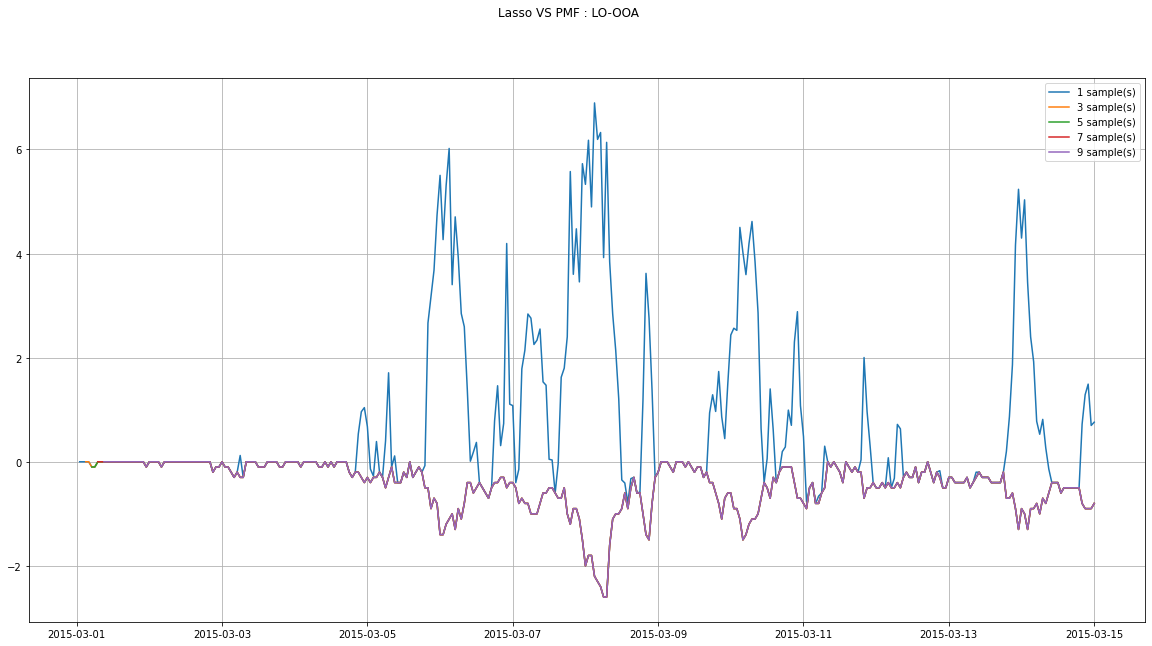

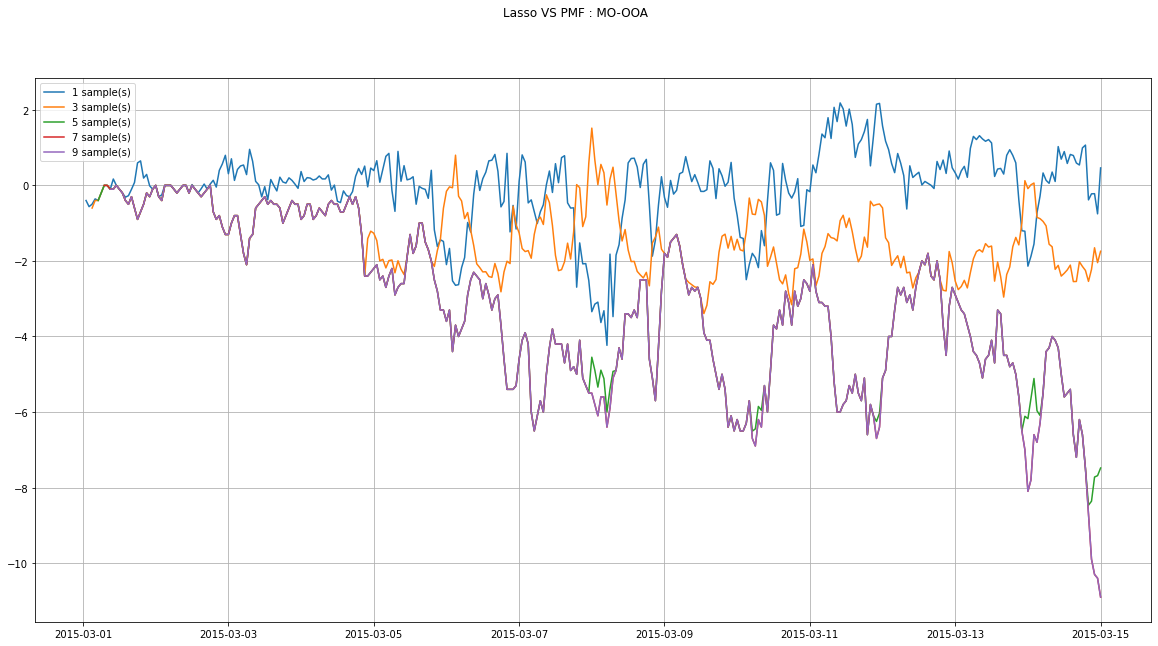

In [29]:
plt.rcParams["figure.figsize"] = (20,10)
for n, prof in enumerate(pro):
    fig, ax = plt.subplots()
    fig.suptitle("Lasso VS PMF : " + prof)
    for i, pas in enumerate(list_pas_2):
        ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_2[i][n] - df_regressor[df_regressor["profile"] == prof].sort_values(by="date")["contribution"].values[pas-1:], label=f'{pas} sample(s)')
    plt.grid()
    plt.legend()
    plt.show()

## IV.d Affichage séparé des différents lissages avec pondération

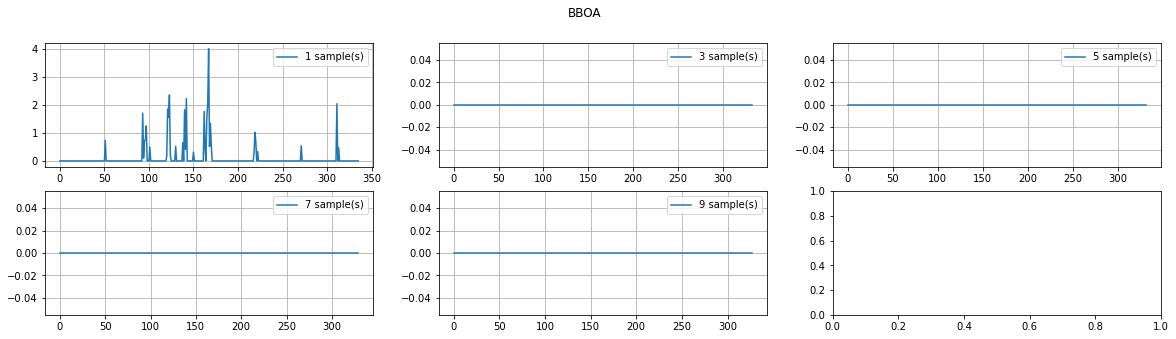

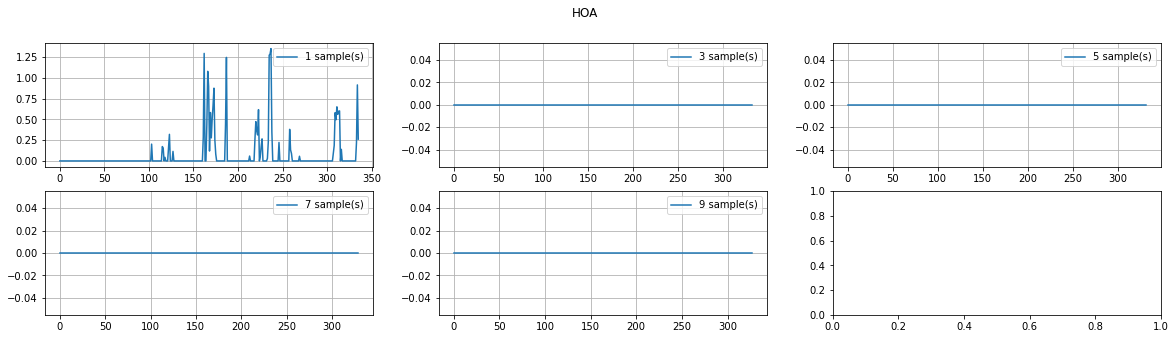

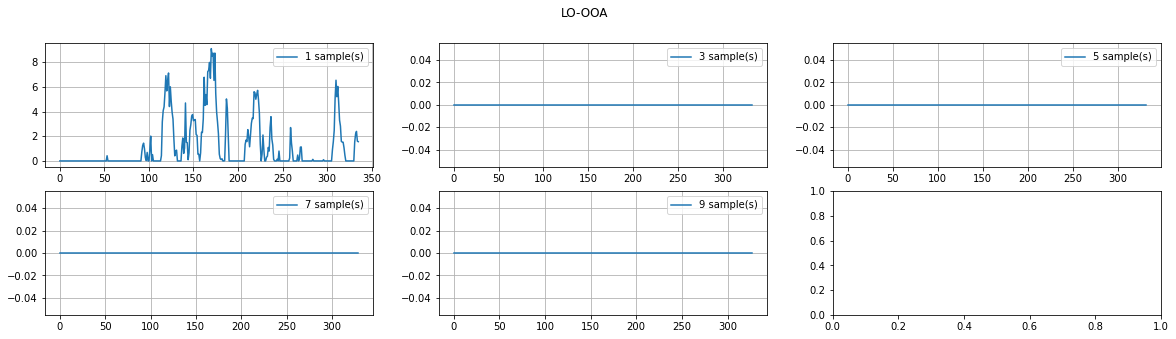

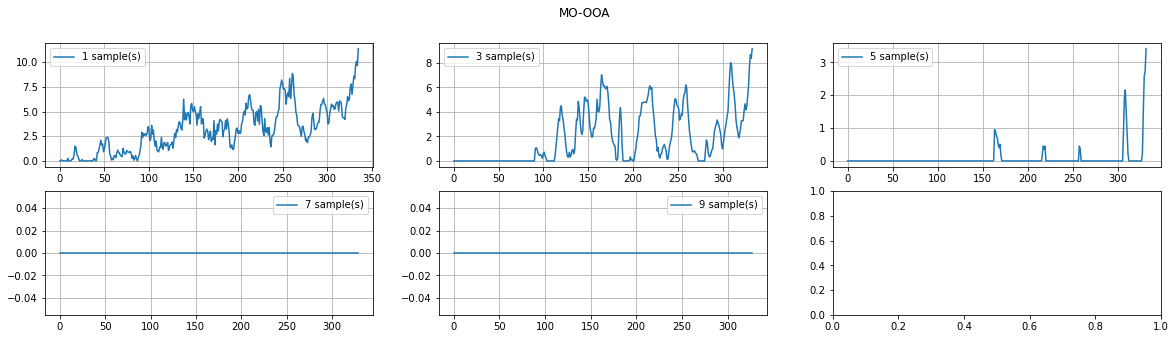

In [30]:
plt.rcParams["figure.figsize"] = (20,5)
for n, prof in enumerate(pro):
    fig, ax = plt.subplots(int(np.ceil(len(list_pas_2) / 3)), min(3, len(list_pas_2)))
    fig.suptitle(prof)
    for i, pas in enumerate(list_pas_2):
        row = int(np.floor(i / 3))
        col = i % 3
        if int(np.ceil(len(list_pas_2) / 3)) == 1:
            ax[col].plot(result_2[i][n], label=f'{pas} sample(s)')
            ax[col].grid()
            ax[col].legend()
        else:
            ax[row][col].plot(result_2[i][n], label=f'{pas} sample(s)')
            ax[row][col].grid()
            ax[row][col].legend()
    plt.show()

## IV.e Affichage des erreurs

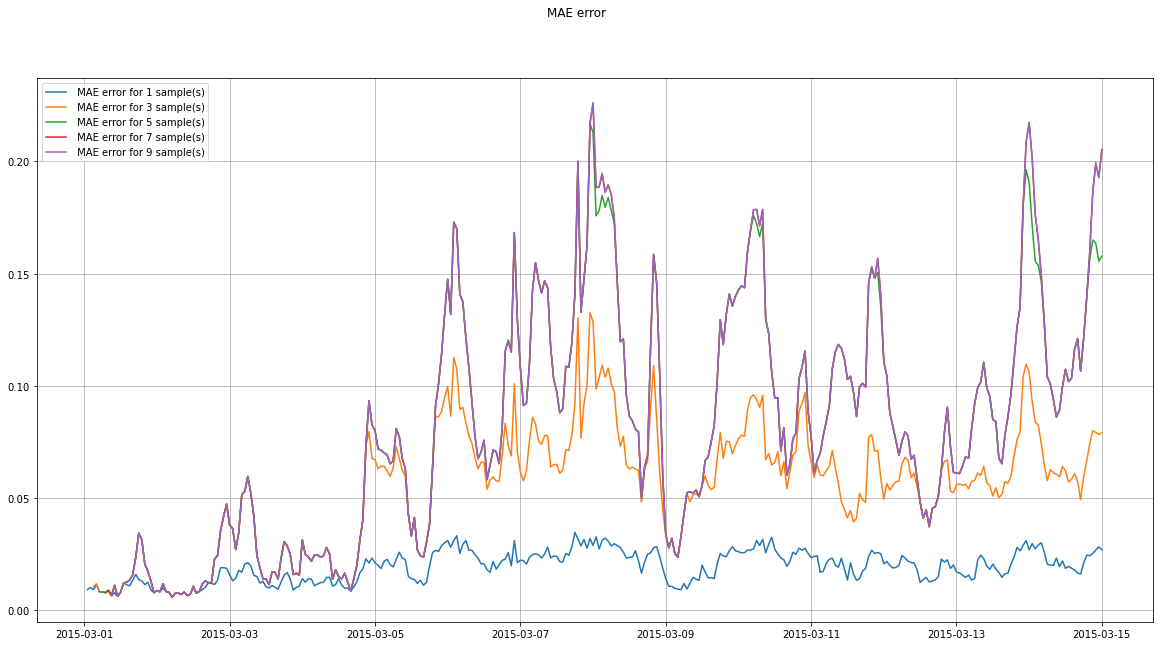

In [31]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MAE error")
for i, pas in enumerate(list_pas):
    ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_2_error_MAE[i], label=f' MAE error for {pas} sample(s)')
plt.grid()
plt.legend()
plt.show()

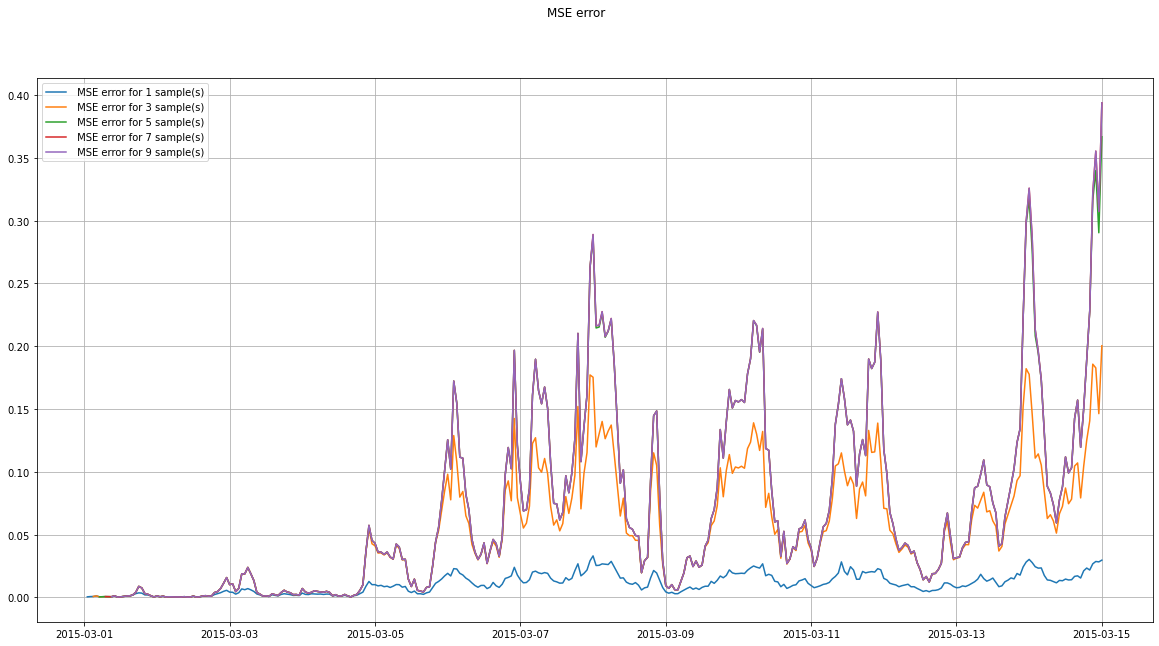

In [32]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MSE error")
for i, pas in enumerate(list_pas):
    ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_2_error_MSE[i], label=f' MSE error for {pas} sample(s)')
plt.grid()
plt.legend()
plt.show()

## IV.f Affichage des erreurs avec le signal brute lissé

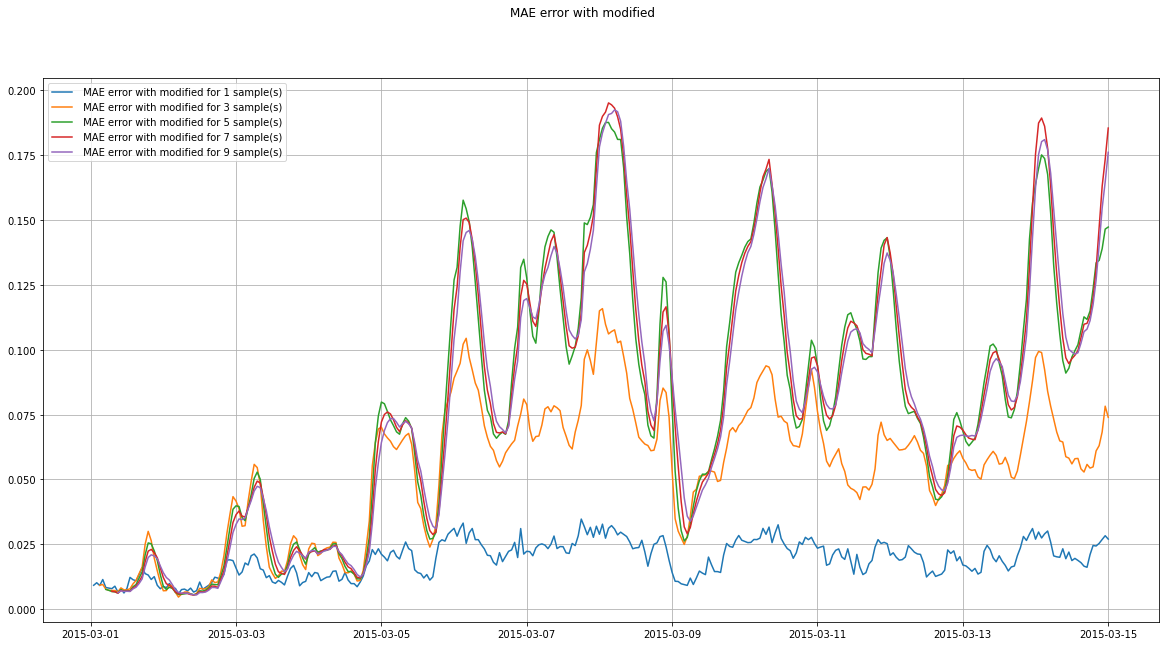

In [33]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MAE error with modified")
for i, pas in enumerate(list_pas):
    ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_2_error_MAE_modified[i], label=f' MAE error with modified for {pas} sample(s)')
plt.grid()
plt.legend()
plt.show()

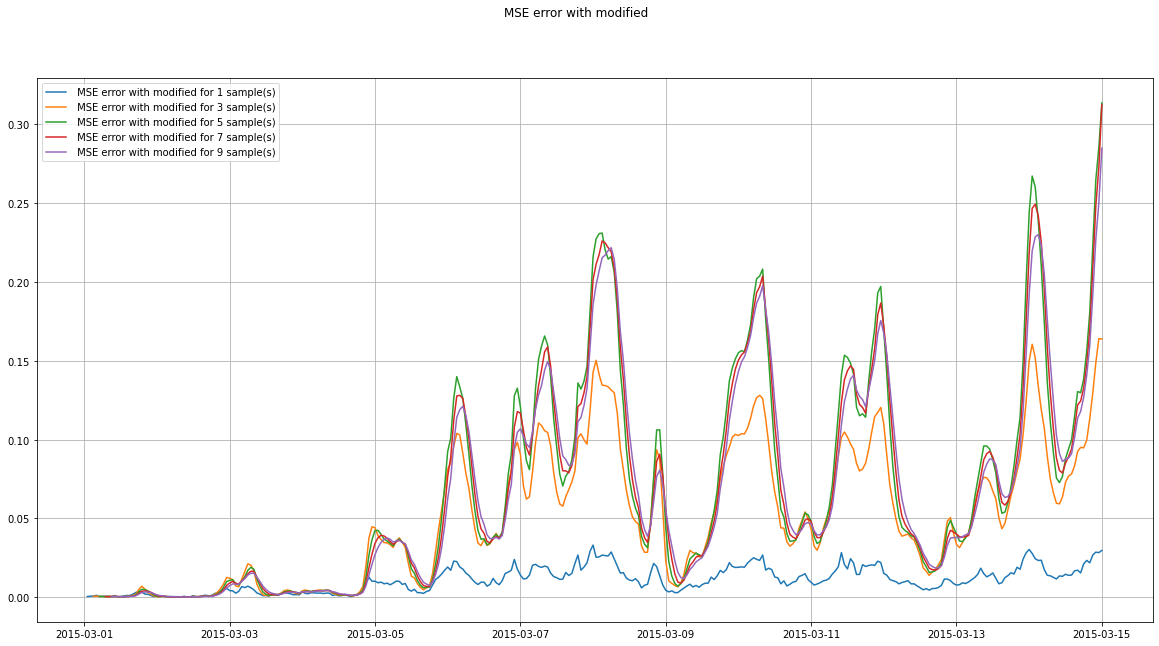

In [34]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MSE error with modified")
for i, pas in enumerate(list_pas):
    ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_2_error_MSE_modified[i], label=f' MSE error with modified for {pas} sample(s)')
plt.grid()
plt.legend()
plt.show()

## IV.g Comparaison avec la PMF

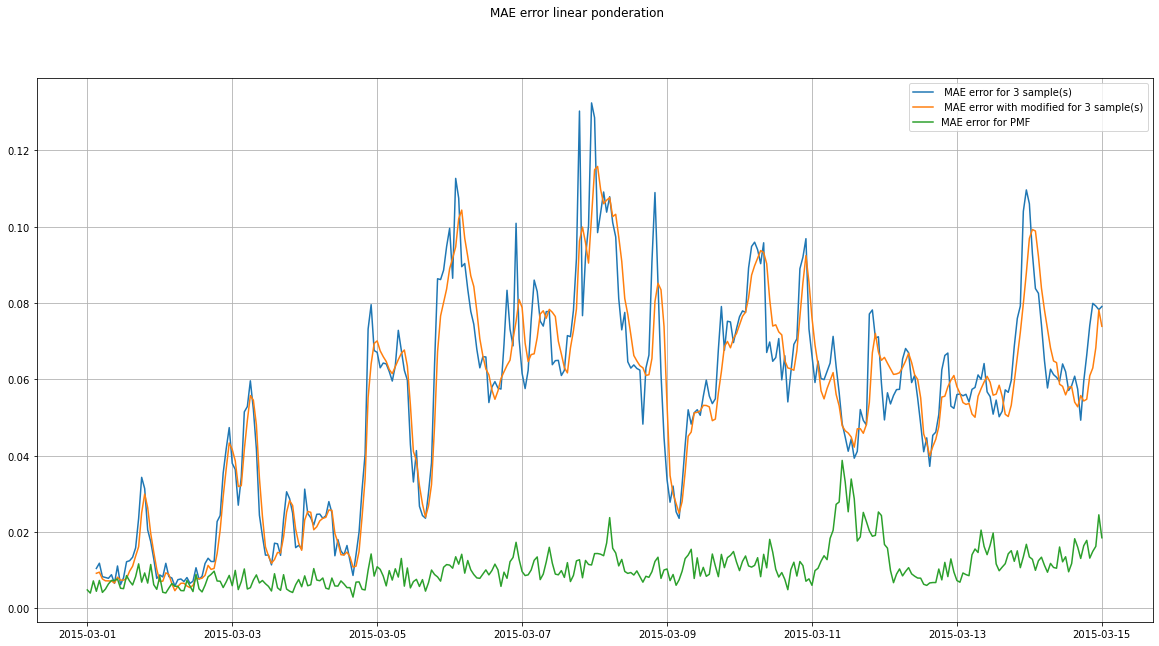

In [35]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MAE error linear ponderation")
i = 1
pas = list_pas[i]
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_2_error_MAE[i], label=f' MAE error for {pas} sample(s)')
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_2_error_MAE_modified[i], label=f' MAE error with modified for {pas} sample(s)')
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates], error_PMF_MAE, label="MAE error for PMF")
plt.grid()
plt.legend()
plt.show()

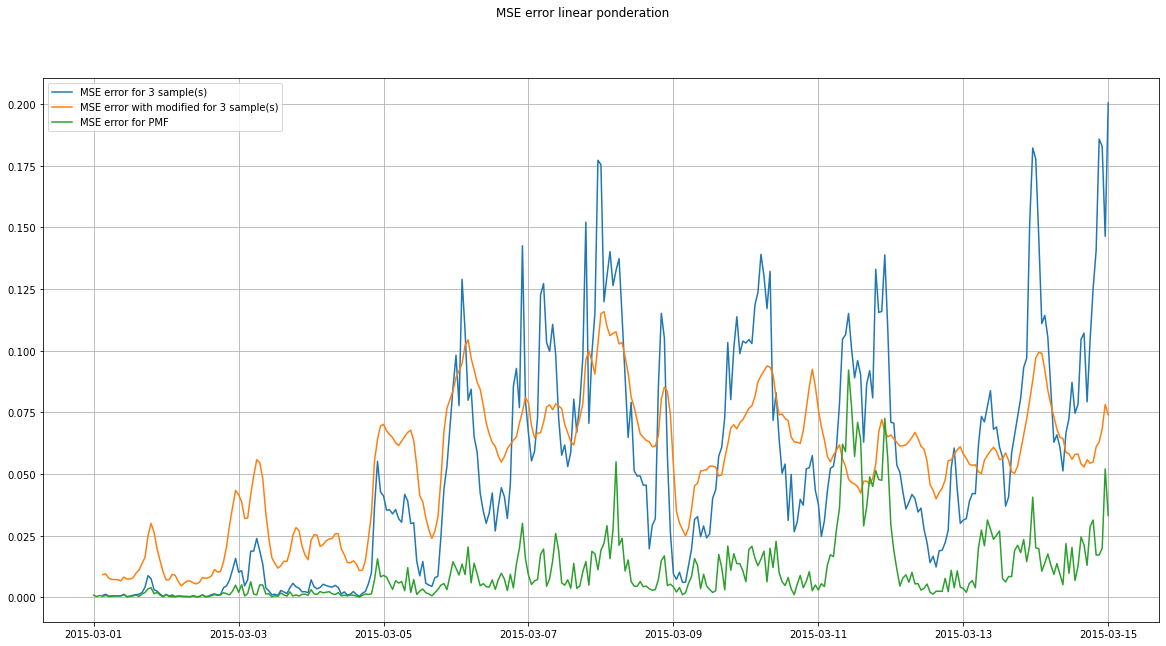

In [36]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MSE error linear ponderation")
i = 1
pas = list_pas[i]
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_2_error_MSE[i], label=f'MSE error for {pas} sample(s)')
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_2_error_MAE_modified[i], label=f'MSE error with modified for {pas} sample(s)')
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates], error_PMF_MSE, label="MSE error for PMF")
plt.grid()
plt.legend()
plt.show()

## IV.h Observations

Observations faites sur les différents niveaux de lissage avec pondération :
- Décalage temporel réduit mais encore présent
- Présence de l'atténuation des niveaux de contribution en fonction du niveau de lissage
- Plus le lissage est important, plus l'erreur est important
- L'erreur globale avec pondération est plus faible que celle sans pondération

# V - Mise en application du lissage avec pondération exponentielle

Dans cette partie, une pondération exponentielle est mise en place. Pour n échantillons pris en compte :
- L'échantillon à t est pondéré à 1
- L'échantillon à t-1 est pondéré à r
- ...
- L'échantillon à t-n+1 est pondéré à r^(n-1)


## V.a Choix du nombre d'échantillons à prendre en compte (3) et du taux de pondération

In [37]:
list_pas_3 = [1,3,5,7,9]
taux = 0.15

In [38]:
lissage_brute_3 = []
for pas in list_pas_3:
    result = []
    for index, date in enumerate(dates[pas:]):
        result_inter = []
        total_coef = 0
        for i in range(pas):
            coef = taux**(pas - 1 - i)
            total_coef += coef
            result_inter.append(coef*df_array[i + index])
        result.append(np.sum(result_inter, axis=0) / total_coef)
    lissage_brute_3.append(result)

## V.b Mise en place de l'algorithme de lissage (avec pondération)

In [39]:
result_3 = []
result_3_error_MAE = []
result_3_error_MSE = []
result_3_error_MAE_modified = []
result_3_error_MSE_modified = []
connection = psycopg2.connect(user = USER, password = PASSWORD, host = HOSTNAME, port = PORT, database = DATABASE)
for index_pas, pas in enumerate(list_pas_3):
    contribution = [[] for i in pro]
    contribution_mae = []
    contribution_mse = []
    contribution_mae_modified = []
    contribution_mse_modified = []
    for index_date, i in enumerate(dates[pas:]):    
        date = i
        sql = f"""SELECT * FROM public.data_receptor where date = '{date}' """
        for k in range(1, pas):
            date_intemediaire = (datetime.strptime(date, '%Y-%m-%d %H:%M:%S')-timedelta(hours=k)).strftime('%Y-%m-%d %H:%M:%S')
            sql += f"or date = '{date_intemediaire}' "
        sql += "order by mass;"
        df_receptor_data = sqlio.read_sql_query(sql, connection)
        df_receptor_data = df_receptor_data[df_receptor_data.columns]

        df_receptor_data_ref = df_receptor_data[df_receptor_data["date"]==i]["value"].values

        # Ponderate values
        for k in range(pas):
            date_target = (datetime.strptime(date, '%Y-%m-%d %H:%M:%S')-timedelta(hours=k)).strftime('%Y-%m-%d %H:%M:%S')
            df_receptor_data.loc[df_receptor_data["date"] == date_target, "coef"] = taux**k
        cor = df.merge(df_receptor_data, left_on='amus', right_on='mass').drop(columns=['mass', 'amus'])

        X_train = cor[pro].values
        y_train = cor['value'].values.reshape(-1,1)

        for index, row in enumerate(X_train):
            X_train[index] = np.dot(row, cor['coef'].iloc[index])

        for index, row in enumerate(y_train):
            y_train[index] = np.dot(row, cor['coef'].iloc[index])

        alpha = 0.001
        lasso = Lasso(fit_intercept=False, alpha=alpha, positive=True)     # We train without intercept and we shoose to have only positive values
        lasso.fit(X_train, y_train)                                         #training the algorithm
        clear_output(wait=True)                                          
        print(pas, ' ', date)
        for n, prof in enumerate(pro):
            contribution[n].append(lasso.coef_[n])

        # Constructed signal
        data_profile = df[pro].values
        construct = np.dot(data_profile, lasso.coef_)

        # MAE error
        error_mae = np.sum(np.abs(construct - df_receptor_data_ref)) / len(df_receptor_data_ref)
        contribution_mae.append(error_mae)

        # MSE error
        error_mse = np.sum(np.abs(construct**2 - df_receptor_data_ref**2)) / len(df_receptor_data_ref)
        contribution_mse.append(error_mse)

        # MAE error
        error_mae = np.sum(np.abs(construct - lissage_brute_3[index_pas][index_date])) / len(construct)
        contribution_mae_modified.append(error_mae)

        # MSE error
        error_mse = np.sum(np.abs(construct**2 - lissage_brute_3[index_pas][index_date]**2)) / len(construct)
        contribution_mse_modified.append(error_mse)

    result_3.append(contribution)
    result_3_error_MSE.append(contribution_mse)
    result_3_error_MAE.append(contribution_mae)
    result_3_error_MSE_modified.append(contribution_mse_modified)
    result_3_error_MAE_modified.append(contribution_mae_modified)

connection.close()
print("Done")

9   2015-03-15 00:00:00
Done


## V.c Affichage superposé des différents lissages avec pondération

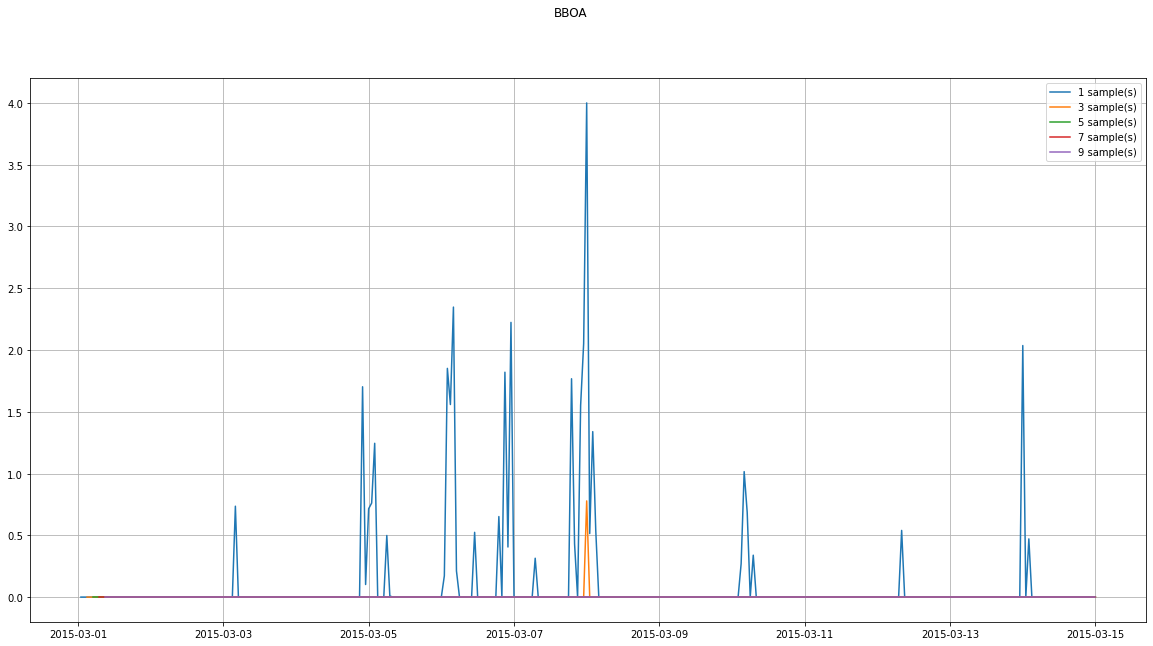

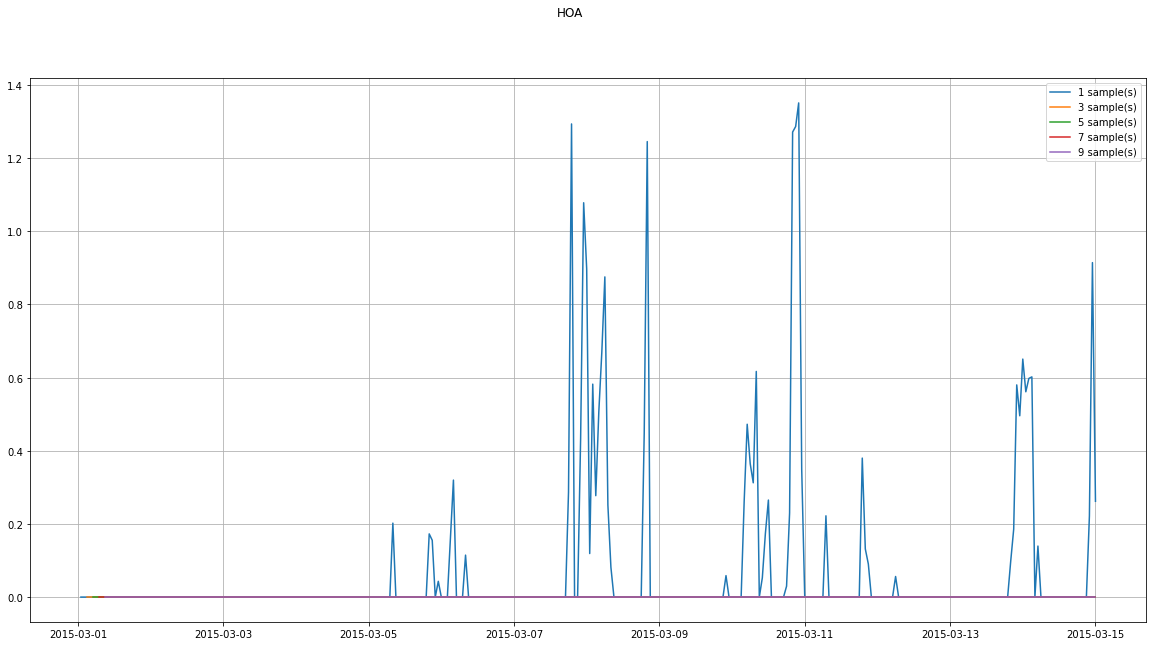

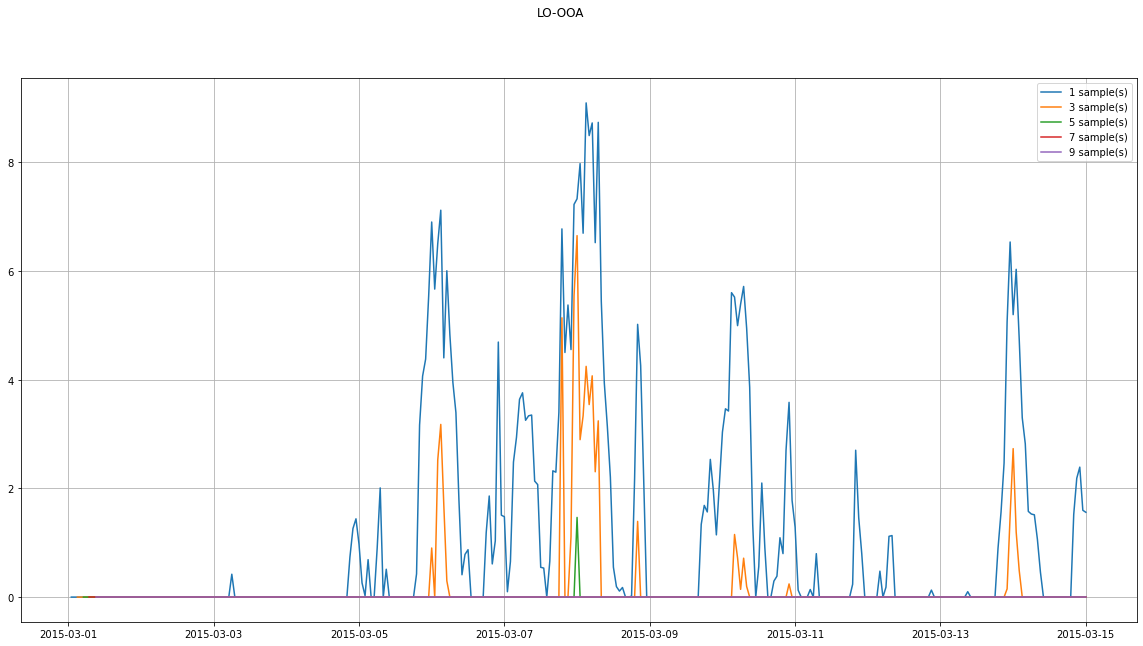

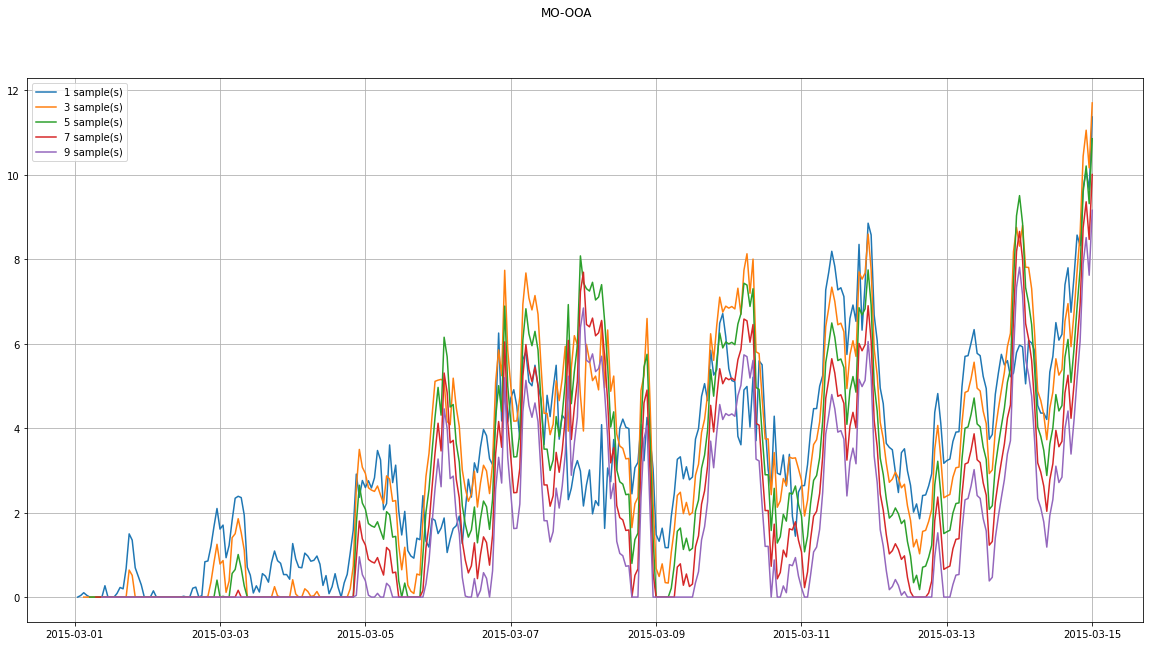

In [40]:
plt.rcParams["figure.figsize"] = (20,10)
for n, prof in enumerate(pro):
    fig, ax = plt.subplots()
    fig.suptitle(prof)
    for i, pas in enumerate(list_pas_3):
        ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_3[i][n], label=f'{pas} sample(s)')
    plt.grid()
    plt.legend()
    plt.show()

## V.d Affichage séparé des différents lissages avec pondération

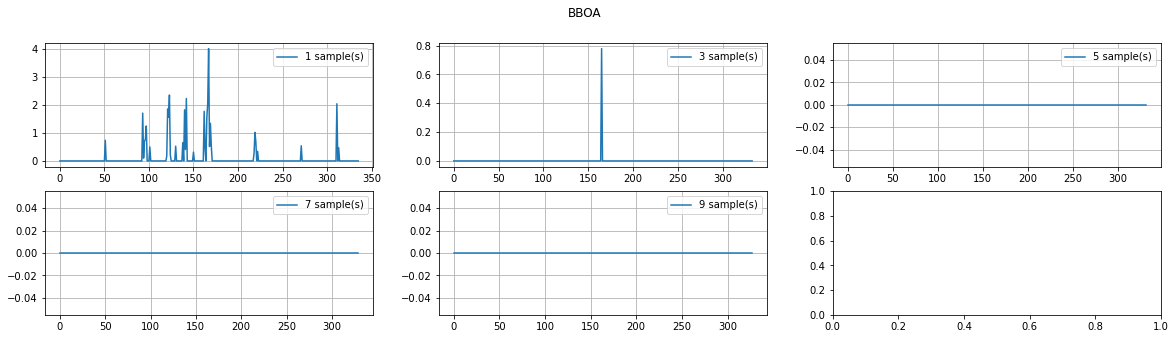

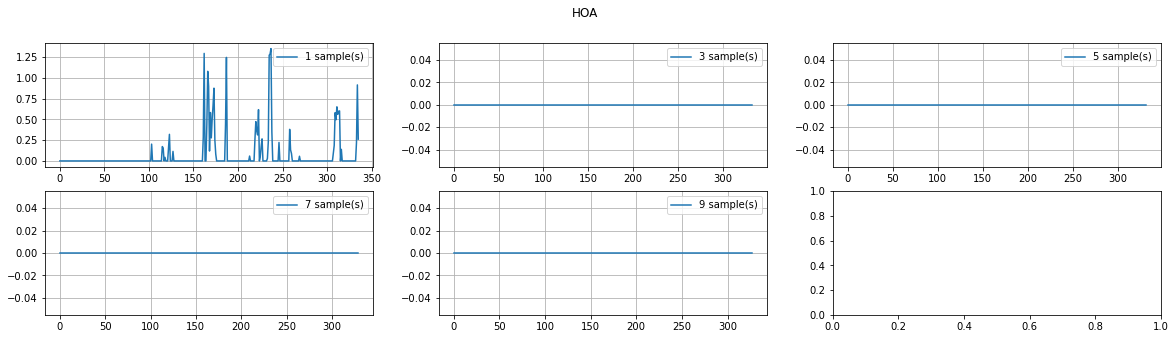

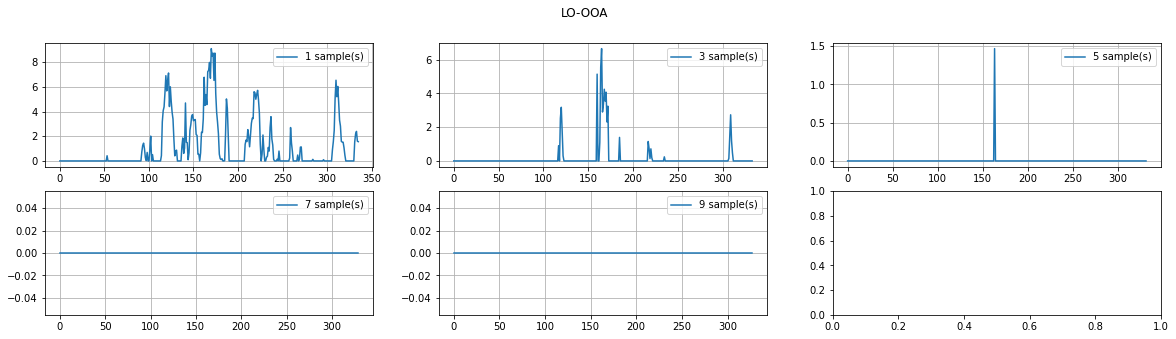

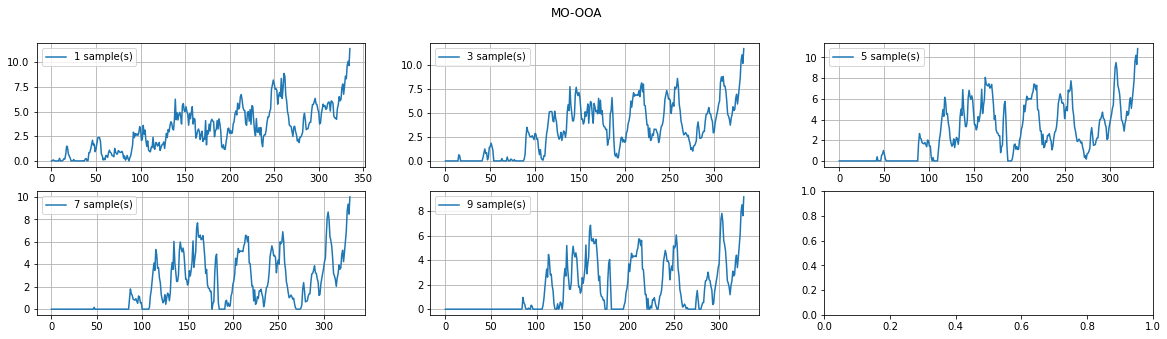

In [41]:
plt.rcParams["figure.figsize"] = (20,5)
for n, prof in enumerate(pro):
    fig, ax = plt.subplots(int(np.ceil(len(list_pas_3) / 3)), min(3, len(list_pas_3)))
    fig.suptitle(prof)
    for i, pas in enumerate(list_pas_3):
        row = int(np.floor(i / 3))
        col = i % 3
        if int(np.ceil(len(list_pas_3) / 3)) == 1:
            ax[col].plot(result_3[i][n], label=f'{pas} sample(s)')
            ax[col].grid()
            ax[col].legend()
        else:
            ax[row][col].plot(result_3[i][n], label=f'{pas} sample(s)')
            ax[row][col].grid()
            ax[row][col].legend()
    plt.show()

## V.e Affichage des erreurs

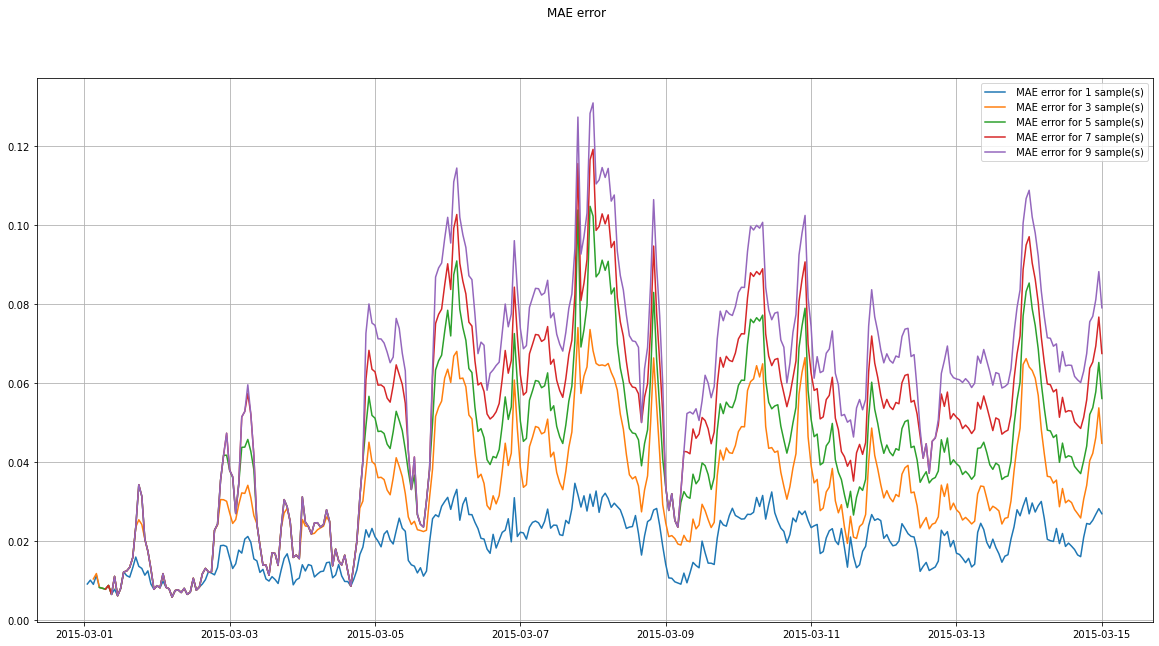

In [42]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MAE error")
for i, pas in enumerate(list_pas):
    ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_3_error_MAE[i], label=f' MAE error for {pas} sample(s)')
plt.grid()
plt.legend()
plt.show()

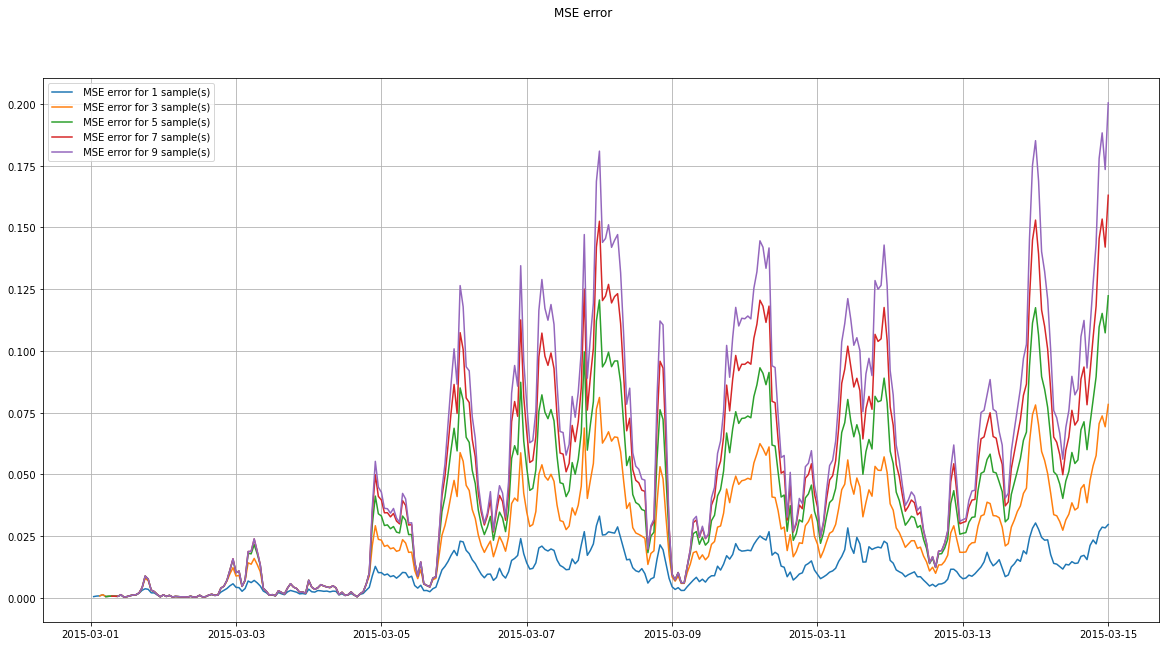

In [43]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MSE error")
for i, pas in enumerate(list_pas):
    ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_3_error_MSE[i], label=f' MSE error for {pas} sample(s)')
plt.grid()
plt.legend()
plt.show()

## V.f Affichage des erreurs avec le signal brut lissé

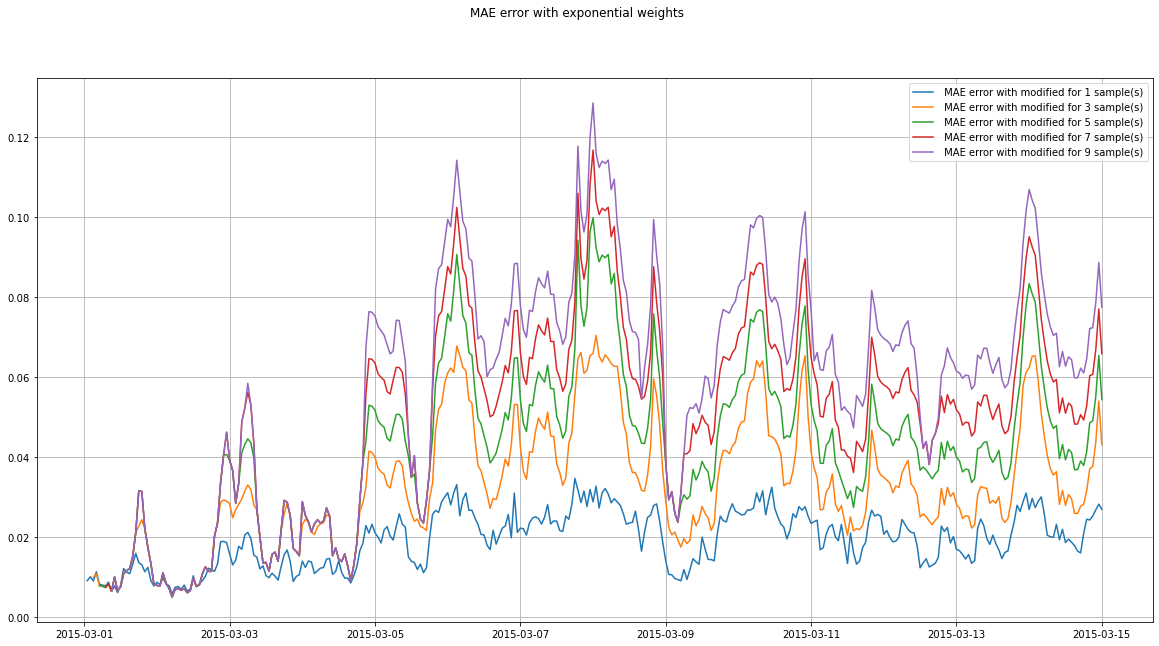

In [44]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MAE error with exponential weights")
for i, pas in enumerate(list_pas):
    ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_3_error_MAE_modified[i], label=f' MAE error with modified for {pas} sample(s)')
plt.grid()
plt.legend()
plt.show()

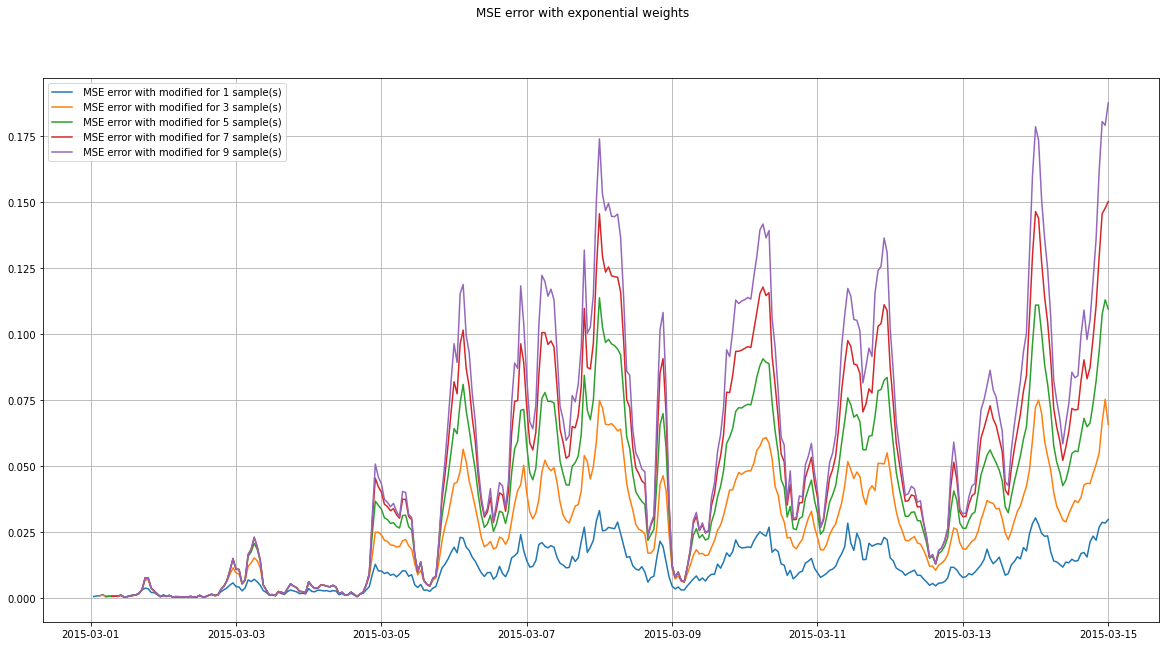

In [45]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MSE error with exponential weights")
for i, pas in enumerate(list_pas):
    ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_3_error_MSE_modified[i], label=f' MSE error with modified for {pas} sample(s)')
plt.grid()
plt.legend()
plt.show()

## V.f Comparaison avec la PMF

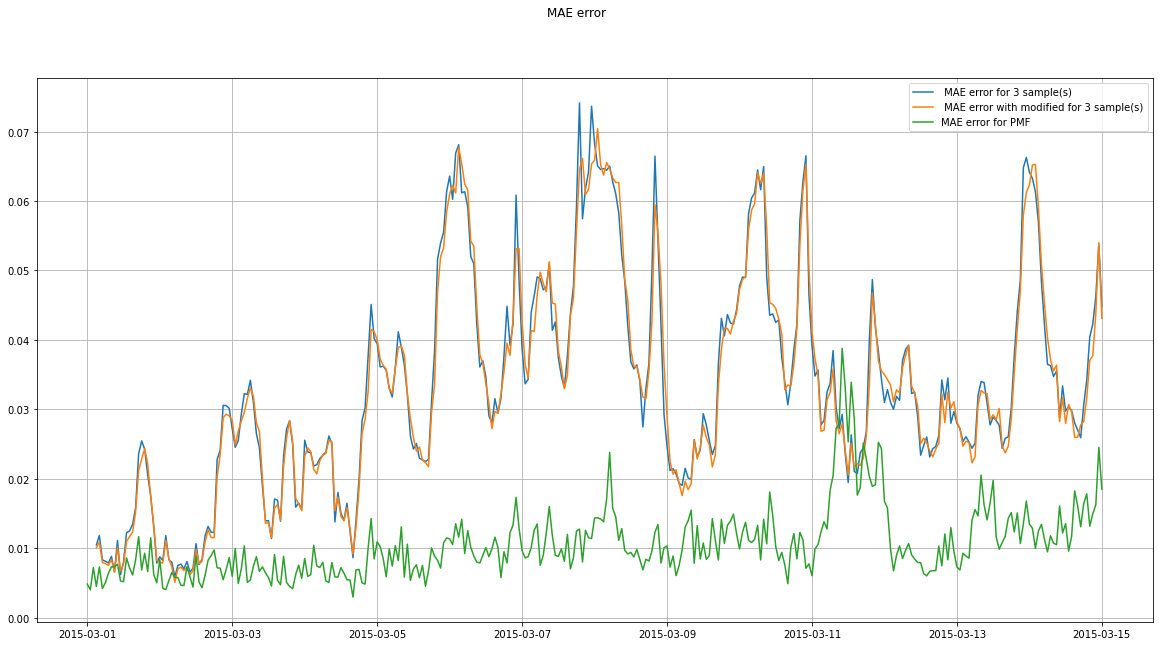

In [46]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MAE error")
i = 1
pas = list_pas[i]
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_3_error_MAE[i], label=f' MAE error for {pas} sample(s)')
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_3_error_MAE_modified[i], label=f' MAE error with modified for {pas} sample(s)')
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates], error_PMF_MAE, label="MAE error for PMF")
plt.grid()
plt.legend()
plt.show()

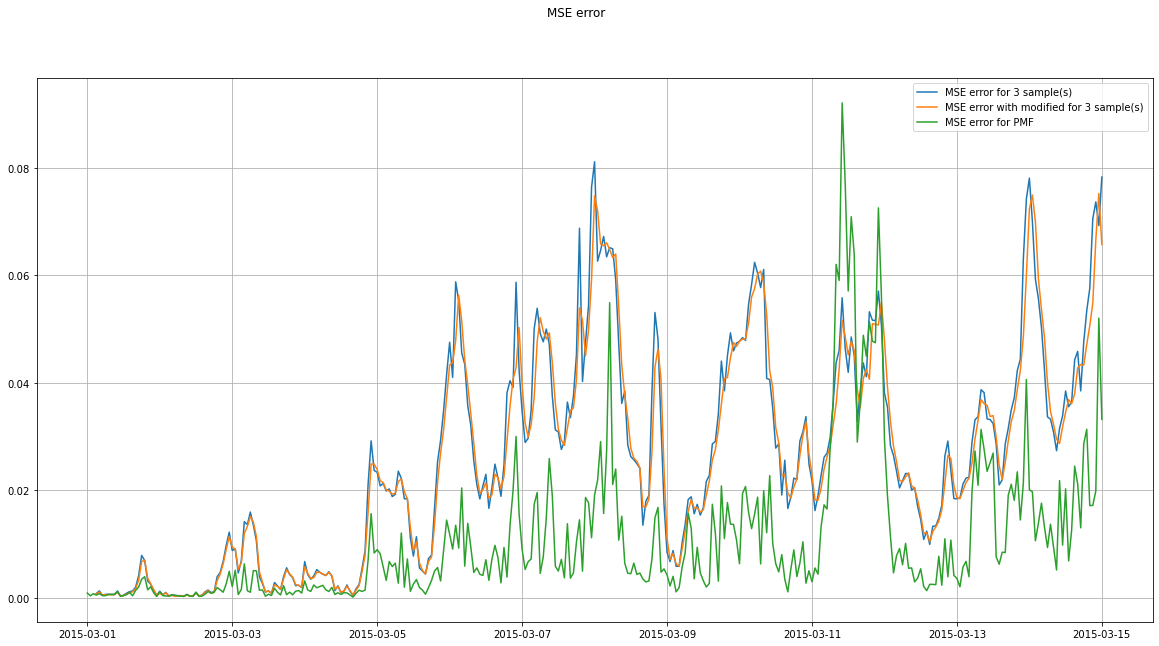

In [47]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
fig.suptitle("MSE error")
i = 1
pas = list_pas[i]
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_3_error_MSE[i], label=f'MSE error for {pas} sample(s)')
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates[pas:]], result_3_error_MSE_modified[i], label=f'MSE error with modified for {pas} sample(s)')
ax.plot([datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dates], error_PMF_MSE, label="MSE error for PMF")
plt.grid()
plt.legend()
plt.show()

## V.g Observations

Observations faites sur les différents niveaux de lissage avec pondération exponentielle :
- Décalage temporel très peu visible
- Présence d'une atténuation ou d'une amplification des niveaux de contribution en fonction du profil
- Plus le lissage est important, plus l'erreur est important
- L'erreur globale avec pondération est plus faible que celle sans pondération
- L'erreur MSE par rapport à celle PMF est inférieure 

# VI - Comparaison entre avec et sans pondération

## VI.a Comparaison des différents lissages

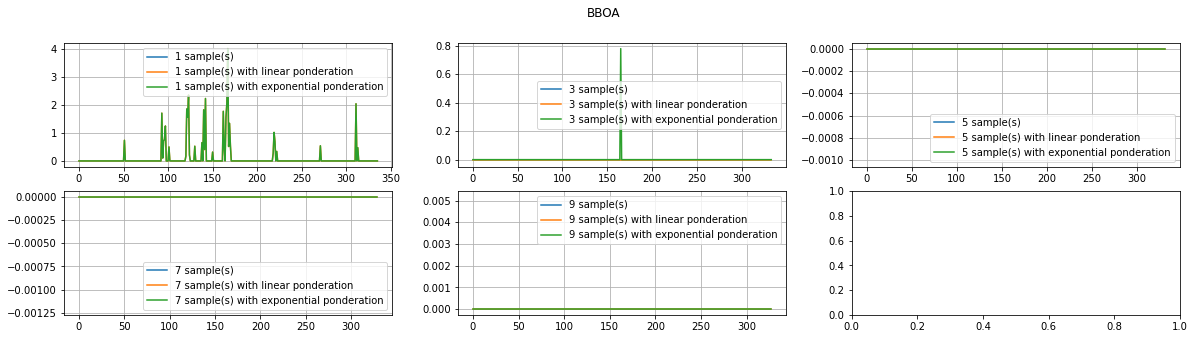

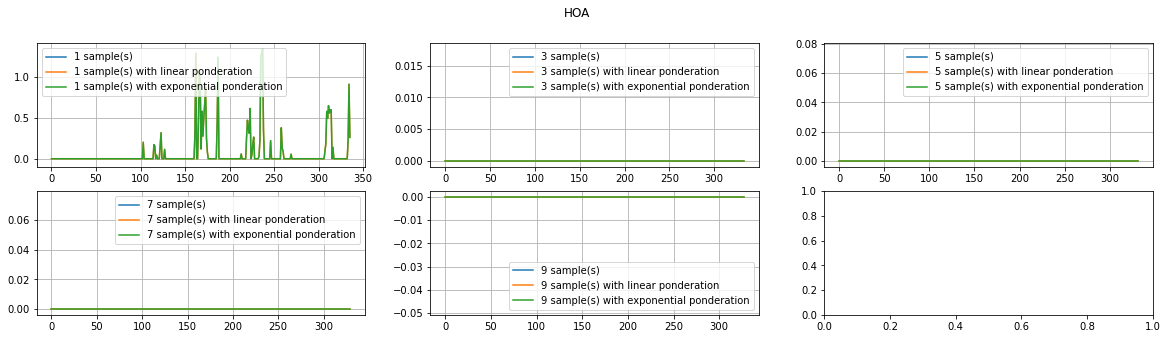

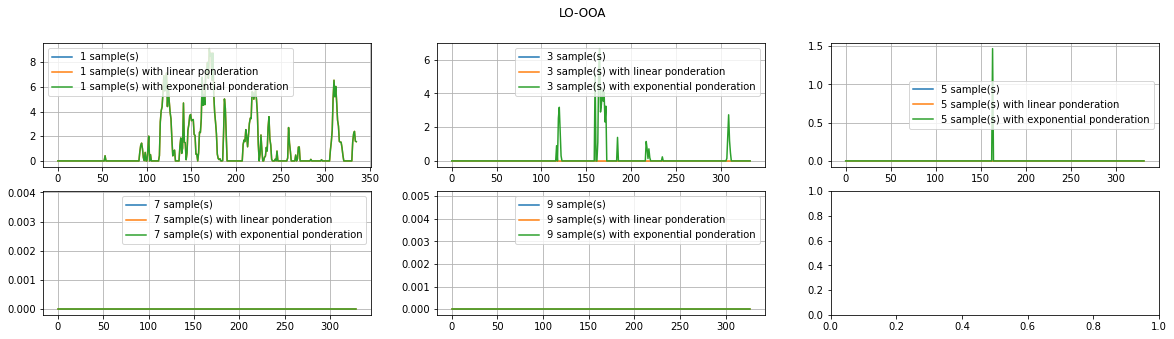

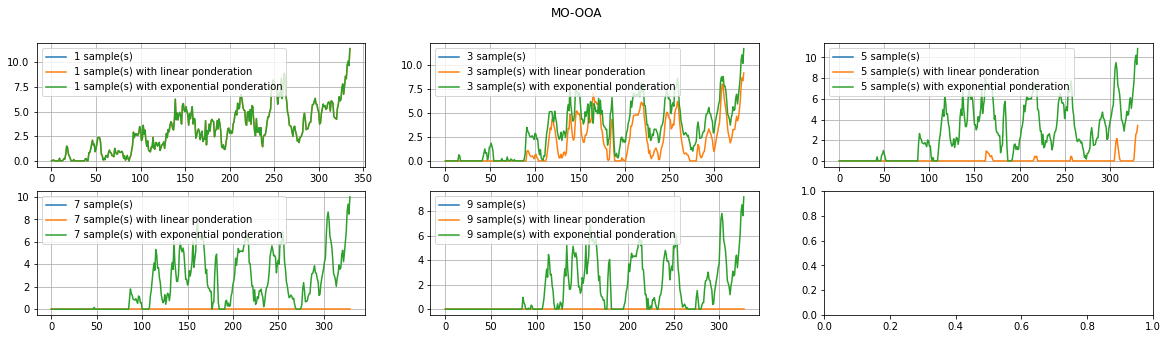

In [48]:
plt.rcParams["figure.figsize"] = (20,5)
for n, prof in enumerate(pro):
    fig, ax = plt.subplots(int(np.ceil(len(list_pas_2) / 3)), min(3, len(list_pas_2)))
    fig.suptitle(prof)
    for i, pas in enumerate(list_pas_2):
        row = int(np.floor(i / 3))
        col = i % 3
        if int(np.ceil(len(list_pas_2) / 3)) == 1:
            ax[col].plot(result[i][n], label=f'{pas} sample(s)')
            ax[col].plot(result_2[i][n], label=f'{pas} sample(s) with linear ponderation')
            ax[col].plot(result_3[i][n], label=f'{pas} sample(s) with exponential ponderation')
            ax[col].grid()
            ax[col].legend()
        else:
            ax[row][col].plot(result[i][n], label=f'{pas} sample(s)')
            ax[row][col].plot(result_2[i][n], label=f'{pas} sample(s) with linear ponderation')
            ax[row][col].plot(result_3[i][n], label=f'{pas} sample(s) with exponential ponderation')
            ax[row][col].grid()
            ax[row][col].legend()
    plt.show()

## VI.b Comparaison des erreurs MAE

In [49]:
data = []
for k, pas in enumerate(list_pas):
    data.append([
        pas,
        np.mean(result_error_MAE[k]),
        np.mean(result_2_error_MAE[k]),
        np.mean(result_3_error_MAE[k])
    ])
data.append([
    'PMF',
    np.mean(error_PMF_MAE),
    np.mean(error_PMF_MAE),
    np.mean(error_PMF_MAE)
])

pd.DataFrame(data=data, columns=["Nb samples", "MAE error", "MAE error with linear ponderation", "MAE error with exponential ponderation"])

Nb samples  MAE error  MAE error with linear ponderation  \
0          1   0.019351                           0.019351   
1          3   0.061331                           0.054341   
2          5   0.069137                           0.079972   
3          7   0.072975                           0.081464   
4          9   0.075615                           0.081910   
5        PMF   0.010537                           0.010537   

   MAE error with exponential ponderation  
0                                0.019351  
1                                0.033360  
2                                0.042809  
3                                0.051178  
4                                0.058951  
5                                0.010537

In [50]:
data = []
for k, pas in enumerate(list_pas):
    data.append([
        pas,
        np.mean(result_error_MAE_modified[k]),
        np.mean(result_2_error_MAE_modified[k]),
        np.mean(result_3_error_MAE_modified[k])
    ])
data.append([
    'PMF',
    np.mean(error_PMF_MAE),
    np.mean(error_PMF_MAE),
    np.mean(error_PMF_MAE)
])

pd.DataFrame(data=data, columns=["Nb samples", "MAE error with modified", "MAE error with modified (with linear ponderation)", "MAE error with modified (with exponential ponderation)"])

Nb samples  MAE error with modified  \
0          1                 0.019351   
1          3                 0.060304   
2          5                 0.067448   
3          7                 0.070730   
4          9                 0.072900   
5        PMF                 0.010537   

   MAE error with modified (with linear ponderation)  \
0                                           0.019351   
1                                           0.053542   
2                                           0.078725   
3                                           0.079802   
4                                           0.079884   
5                                           0.010537   

   MAE error with modified (with exponential ponderation)  
0                                           0.019351       
1                                           0.033043       
2                                           0.042510       
3                                           0.050905       
4                                           0.058692       
5                                           0.010537

## VI.c Comparaison des erreurs MSE

In [51]:
data = []
for k, pas in enumerate(list_pas):
    data.append([
        pas,
        np.mean(result_error_MSE[k]),
        np.mean(result_2_error_MSE[k]),
        np.mean(result_3_error_MSE[k])
    ])

data.append([
    'PMF',
    np.mean(error_PMF_MSE),
    np.mean(error_PMF_MSE),
    np.mean(error_PMF_MSE)
])
pd.DataFrame(data=data, columns=["Nb samples", "MSE error", "MSE error with linear ponderation", "MSE error with exponential ponderation"])

Nb samples  MSE error  MSE error with linear ponderation  \
0          1   0.010858                           0.010858   
1          3   0.064113                           0.051524   
2          5   0.068671                           0.070885   
3          7   0.070339                           0.071624   
4          9   0.071333                           0.072057   
5        PMF   0.010755                           0.010755   

   MSE error with exponential ponderation  
0                                0.010858  
1                                0.025823  
2                                0.038035  
3                                0.047953  
4                                0.055761  
5                                0.010755

In [52]:
data = []
for k, pas in enumerate(list_pas):
    data.append([
        pas,
        np.mean(result_error_MSE_modified[k]),
        np.mean(result_2_error_MSE_modified[k]),
        np.mean(result_3_error_MSE_modified[k])
    ])

data.append([
    'PMF',
    np.mean(error_PMF_MSE),
    np.mean(error_PMF_MSE),
    np.mean(error_PMF_MSE)
])
pd.DataFrame(data=data, columns=["Nb samples", "MSE error with modified", "MSE error with modified (with linear ponderation)", "MSE error with modified (with exponential ponderation)"])

Nb samples  MSE error with modified  \
0          1                 0.010858   
1          3                 0.062149   
2          5                 0.064905   
3          7                 0.064935   
4          9                 0.064518   
5        PMF                 0.010755   

   MSE error with modified (with linear ponderation)  \
0                                           0.010858   
1                                           0.050017   
2                                           0.068053   
3                                           0.067525   
4                                           0.066798   
5                                           0.010755   

   MSE error with modified (with exponential ponderation)  
0                                           0.010858       
1                                           0.025336       
2                                           0.037519       
3                                           0.047439       
4                                           0.055249       
5                                           0.010755

# Conclusion Globale

Pour résumer :
- Différents lissages ont été appliqués (de 1 à 11 échantillons ont été pris en compte)
- 3 types de lissage :
    - Sans pondération
    - Pondération linéaire
    - Pondération exponentielle
- Plus le lissage est important, effet d'atténuation ou d'amplification devient marqué
- Plus le lissage est important, plus le retard temporel est conséquent
- En terme d'erreur : Sans pondération < Pondération linéaire < Pondération exponentielle


## Récaptiualtif de la réunion précédente et des résultats

- Contexte de l’étude réalisée :
    - Données focalisées sur une courte période (du 01/03/2015 au 15/03/2015)
    - Seuls les spectres obtenus par le site du SIRTA sont utilisés
    - Les 4 profils obtenus sur le site du SIRTA sont utilisés pour l’étude du lissage
    - Plusieurs pondérations ont été étudiées


- Observations du lissage sans mise en place de pondération :
    - Présence d’un décalage temporel qui s’accentue lorsque le nombre d’échantillons pris en compte augmente
    - Si l’effet de lissage est important (ie le nombre d'échantillons), l’atténuation des valeurs de contribution l’est aussi
    - L’erreur MAE et MSE (en utilisant le spectre reconstruit) augmentent en fonction du nombre d’échantillons pris en compte dans le lissage : cela peut s’expliquer par le décalage temporel observé précédemment
    - Comparé à l’erreur de la méthode PMF, le lissage sans pondération possède une erreur plus importante
    

- Observations sur le lissage avec une pondération linéaire :
    - Décalage temporel atténué mais toujours perceptible
    - Même phénomène concernant l'atténuation des valeurs de contribution
    - Même phénomène concernant les erreurs MAE et MSE, cependant, l’erreur est plus faible que celle sans pondération
    - Comparé à l’erreur de la méthode PMF, difficulté à conclure : sur certaines périodes, l’erreur liée au lissage est au-dessus et inversement.